## MIDI Data Combination V5
(1). 기준
- tick
- sec 0.1 초 단위

(2). precheck
- track 길이 / track_name 동일
- 시간 길이 거의 비슷

### 피아노 Midi 사이트
- https://www.freepianotutorials.net/2023/12/ludwig-goransson-can-you-hear-music.html#more
- http://www.piano-midi.de/bach.htm

### Ⅰ. 라이브러리

In [1]:
import os
import editdistance
import numpy as np
import pandas as pd
import ast

import mido
from mido import MidiFile, MidiTrack, MetaMessage, Message
from tqdm.notebook import tqdm

from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
data_folder = "midi_data/"

In [3]:
sec_base = True
seq_base = True

sec_unit  = 0.1

In [4]:
###################################################
############  트랙 기본 정보
###################################################

def print_midi_info(mid):
    
    print("파일 이름: ", mid.filename)
    print("총 재생 시간: ", mid.length)
    
    if mid.tracks:
        total_tracks = len(mid.tracks)
        
        print("-"*70)
        print("트랙 이름: ", mid.tracks[0].name)
        print("총 트랙의 수: ", total_tracks)
        
        for i in range(total_tracks):
            if mid.tracks[i].name:
                track_name = mid.tracks[i].name
            else:
                track_name = None
            
            print(f"[{i+1}]. {mid.tracks[i].name}")
        
    else:
        print("트랙이 없습니다")

In [5]:
def load_midi_data(input_name, target_name):
    input_path  = os.path.join(data_folder, input_name)
    target_path = os.path.join(data_folder, target_name)
    
    input_mid  = mido.MidiFile(input_path)
    target_mid = mido.MidiFile(target_path)
    
    print("="*20, "[Input Midi Data]", "="*20)
    print_midi_info(input_mid)
    
    print()
    
    print("="*20, "[Target Midi Data]", "="*20)
    print_midi_info(target_mid)
    
    return input_mid, target_mid

### Ⅱ. 데이터 추출하기

In [6]:
def load_mid_Info_from_csv(input_mid, target_mid):
    
    input_name  = input_mid.filename
    target_name = target_mid.filename
    
    input_csv  = input_name.split(".")[0]+".csv"
    target_csv = target_name.split(".")[0]+".csv"
    
    input_info = pd.read_csv(input_csv)
    target_info = pd.read_csv(target_csv)
    
    #input_info = pd.read_csv(input_csv, index_col = 0)
    #target_info = pd.read_csv(target_csv, index_col = 0)
    
    return input_info, target_info

#### [1]. PreCheck
- track 길이
- track 이름
- 음의 길이

In [7]:
def pre_check(input_mid, target_mid):
    input_track_len  = len(input_mid.tracks)
    target_track_len = len(target_mid.tracks)
    
    # track 길이 비교
    if input_track_len != target_track_len:
        print(f"input track len({input_track_len}) != target track len({target_track_len})")
        return False
    
    # track_name 비교
    input_track_name  = [ msg.name for msg in input_mid if msg.type == 'track_name']
    target_track_name = [ msg.name for msg in target_mid if msg.type == 'track_name']
    
    if input_track_name != target_track_name:
        print(f"input track name({input_track_name}) != target track name({target_track_name})")
        return False
    
    # track 시간 비교 ( time_diff_interval 이상 비교 불가)
    input_mid_time  = input_mid.length
    target_mid_time = target_mid.length
    
    time_diff_interval = 20
    
    if abs(input_mid_time - target_mid_time) > time_diff_interval:
        print(f"input time({input_mid_time}) != target time({target_mid_time})")
        return False
    
    return True


#### [2]. MetaMessage

#### [3]. Message
- mean_velocity ( 평균 세기 ) : (( 셈여림 ))에 활용
- diff_velocity ( 세기 변화 ) 
    - 현재 노트의 평균 세기 - 이전 노트의 평균 세기
    - 음표의 세기, 빠르기의 변화에 활용
- dynamic ( 셈여림 )
|셈여림(dynamic)|정의|평균 velocity 범위|
|:--:|:--:|:--:|
|ppp(피아니시시모)|아주 여리게|0~35|
|pp(피아니시모)|매우 여리게|36~48|
|p(피아노)|여리게|49~61|
|mp(메조 피아노)|조금 여리게|62~74|
|mf(메조 포르테)|조금 세게|75~87|
|f(포르테)|세게|88~100|
|ff(포르티시모)|매우 세게|101~113|
|fff(포르티시시모)|아주 세게|114~127|

In [8]:
def create_df_info():
    #df_col = ['sec',
    #          'msg_type', 'channel', 'note', 'velocity', 'dynamic', 'accent', 'count',
    #          'main_vol','depth', 'pedal', 'pan', 'tempo']
    
    df_col = ['sec',
              'msg_type', 'channel', 'note', 'velocity', 'dynamic', 'accent', 'count',
              'main_vol','depth', 'pedal', 'pan']
    df = pd.DataFrame(columns = df_col)
    
    df_tempo_col = ['tempo', 'tick']
    df_tempo = pd.DataFrame(columns = df_tempo_col)

    df_info = { MetaMessage:{}, Message:df }
    
    return df_info, df_tempo

def info_to_list(cur_info):
    
    #cur_temp = [cur_info['sec'],
    #            cur_info['msg_type'], cur_info['channel'], cur_info['note'], 
    #            cur_info['velocity'], cur_info['dynamic'], cur_info['accent'], cur_info['count'],
    #            cur_info['main_vol'], cur_info['depth'], cur_info['pedal'], cur_info['pan'], cur_info['tempo']]
    
    cur_temp = [cur_info['sec'],
                cur_info['msg_type'], cur_info['channel'], cur_info['note'], 
                cur_info['velocity'], cur_info['dynamic'], cur_info['accent'], cur_info['count'],
                cur_info['main_vol'], cur_info['depth'], cur_info['pedal'], cur_info['pan']]
    return cur_temp
                

def initialize_cur_info():
    # cur_info = {'sec':0,
    #            'msg_type': [], 'channel':[], 'note':[],  'velocity':[], 'dynamic':"", 'accent':0, 'count':0,
    #            'main_vol':-1, 'depth':-1, 'pedal':-1, 'pan':-1, 'tempo':[] }
    
    cur_info = {'sec':0,
                'msg_type': [], 'channel':[], 'note':[],  'velocity':[], 'dynamic':"", 'accent':0, 'count':0,
                'main_vol':-1, 'depth':-1, 'pedal':-1, 'pan':-1}
    return cur_info

def check_not_list(msg_list):
    if type(msg_list) == list:
        return msg_list
    else:
        msg_list = [msg_list]
        return msg_list

In [9]:
def tempo_info_list(mid_info, tempo_info):
    
    #default tempo setting
    if 'set_tempo' not in mid_info[MetaMessage]:
        msg = mido.MetaMessage('set_tempo', tempo = 500000)
        
        mid_info[MetaMessage][msg.type] = [msg]
    
    tempo_list = mid_info[MetaMessage]['set_tempo']
    
    tempo_tick = 0
    
    for idx, msg in enumerate(tempo_list):
        tempo_tick += msg.time
            
        if idx==0:
            tempo_info.loc[idx,'tempo'] = msg.tempo
        else:
            tempo_info.loc[idx, 'tempo'] = msg.tempo
            tempo_info.loc[idx-1, 'tick'] = tempo_tick
            
    tempo_info.loc[tempo_info.shape[0] - 1, 'tick'] = -1
                    
    return tempo_info

def find_tempo(tick, tempo_info):
    tempo_idx = 0
    last_tempo_idx = tempo_info.shape[0]
    
    cur_tempo = -1
    
    for tempo_idx in range(last_tempo_idx):
        if tempo_info.loc[tempo_idx, 'tick'] > tick:
            cur_tempo = tempo_info.loc[tempo_idx, 'tempo']
            break
            
    if cur_tempo == -1:
        cur_tempo = tempo_info.loc[last_tempo_idx - 1, 'tempo']
        
    return cur_tempo

In [10]:
# 백업
"""
def distribute_dynamic(mean_velocity):
    dynamic = ''
    if 0 <= mean_velocity < 36:
        dynamic = 'ppp'
    elif 36 <= mean_velocity < 49:
        dynamic = 'pp'
    elif 49 <= mean_velocity < 62:
        dynamic = 'p'
    elif 62 <= mean_velocity < 75:
        dynamic = 'mp'
    elif 75 <= mean_velocity < 88:
        dynamic = 'mf'
    elif 88 <= mean_velocity < 101:
        dynamic = 'f'
    elif 101 <= mean_velocity < 114:
        dynamic = 'ff'
    elif 114 <= mean_velocity <= 127:
        dynamic = 'fff'
    
    return dynamic
"""

"\ndef distribute_dynamic(mean_velocity):\n    dynamic = ''\n    if 0 <= mean_velocity < 36:\n        dynamic = 'ppp'\n    elif 36 <= mean_velocity < 49:\n        dynamic = 'pp'\n    elif 49 <= mean_velocity < 62:\n        dynamic = 'p'\n    elif 62 <= mean_velocity < 75:\n        dynamic = 'mp'\n    elif 75 <= mean_velocity < 88:\n        dynamic = 'mf'\n    elif 88 <= mean_velocity < 101:\n        dynamic = 'f'\n    elif 101 <= mean_velocity < 114:\n        dynamic = 'ff'\n    elif 114 <= mean_velocity <= 127:\n        dynamic = 'fff'\n    \n    return dynamic\n"

In [11]:
###################################################
############  셈여림 정보
###################################################
def distribute_dynamic(mean_velocity):
    dynamic = ''
    if 0 <= mean_velocity < 36:
        dynamic = 'ppp'
    elif 36 <= mean_velocity < 49:
        dynamic = 'pp'
    elif 49 <= mean_velocity < 62:
        dynamic = 'p'
    elif 62 <= mean_velocity < 75:
        dynamic = 'mp'
    elif 75 <= mean_velocity < 88:
        dynamic = 'mf'
    elif 88 <= mean_velocity < 101:
        dynamic = 'f'
    elif 101 <= mean_velocity < 114:
        dynamic = 'ff'
    elif 114 <= mean_velocity <= 127:
        dynamic = 'fff'
    
    return dynamic

###################################################
############  셈여림, 악센트 계산 함수
###################################################
def calculate_dynamic_accent(cur_info, msg_df):
    
    last_idx = msg_df.shape[0]
    
    if last_idx > 0:
        prev_velo = msg_df.loc[last_idx-1, 'velocity']
        prev_avg_velo = sum(prev_velo) / len(prev_velo) if prev_velo else 0
    else:
        prev_avg_velo = 0
        
    if cur_info['count'] > 0:
        mean_velocity = sum(cur_info['velocity']) / len(cur_info['velocity'])
        diff_velocity = mean_velocity - prev_avg_velo
        dynamic = distribute_dynamic(mean_velocity)
    else:
        mean_velocity = 0
        diff_velocity = 0
        dynamic = ''
    
    accent = 1 if 76 <= mean_velocity <= 127 and mean_velocity > 1.2 * prev_avg_velo else 0
    
    return dynamic, accent

In [12]:
def control_type(msg):
    
    ctl_type = None
    
    if msg.control == 1:
        ctl_type = 'modulation'
        
    elif msg.control == 7:
        ctl_type = 'main_vol'
        
    elif msg.control == 10:
        ctl_type = 'pan'
        
    elif msg.control == 64:
        ctl_type = 'pedal'
        
    elif msg.control >= 91 and msg.control <= 93:
        ctl_type = 'depth'
        
    return ctl_type

In [13]:
def process_msg(msg, info):
    
    if msg.type == 'note_on':
        
        if msg.type == 'note_on' and msg.velocity == 0:
            msg_type = 'note_off'
        else:
            msg_type = msg.type
                    
        info['msg_type'].append(msg_type)
        info['channel'].append(msg.channel)
        info['note'].append(msg.note)
        info['velocity'].append(msg.velocity)
                    
        info['count']+=1
        
    elif msg.type == 'program_change':
        print("program_change")
        return False
        
    elif msg.type == 'control_change':
        
        ctl_type = control_type(msg)
        
        # 수집하지 않은 control_type
        if ctl_type == None:
            return False
        
        if info[ctl_type] == -1:
            info[ctl_type] = msg.value
        else:
            info[ctl_type] = check_not_list(info[ctl_type])
            info[ctl_type].append(msg.value)
    
    return True

In [14]:
def remain_check(info):
    
    if info['count'] > 0:
        return True
    
    if info['main_vol'] != -1:
        return True
    
    if info['depth'] != -1:
        return True
    
    if info['pedal'] != -1:
        return True
    
    if info['pan'] != -1:
        return True
    
    return False

In [15]:
def extract_mid_data(mid):
    
    mid_info, tempo_info = create_df_info()
    tick_base = True
    
    for idx, track in enumerate(mid.tracks):
        
        cur_tick = 0
        cur_sec  = 0
        cur_info = initialize_cur_info()
        
        
        for i, msg in tqdm(enumerate(track)):
            
            # MetaMessage
            if isinstance(msg, MetaMessage):
                                
                if msg.type not in mid_info[MetaMessage]:
                    mid_info[MetaMessage][msg.type] = []
                    
                mid_info[MetaMessage][msg.type].append(msg)
            
            elif isinstance(msg, Message):
                
                cur_tick = cur_tick + msg.time
                
                msg_tempo = find_tempo(cur_tick, tempo_info)
                msg_sec = mido.tick2second( cur_tick, mid.ticks_per_beat, msg_tempo )
                msg_sec = np.trunc(msg_sec*10) / 10 # 소수 첫째 자리까지 버림
                
                if msg_sec > cur_sec:                        
                    
                    dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])
                    
                    cur_info['dynamic'] = dynamic
                    cur_info['accent'] = accent
                    
                    cur_info['sec'] = cur_sec
                    
                    cur_temp = info_to_list(cur_info)
                    
                    info_cur = int(msg_sec * 10)
                    info_last = mid_info[Message].shape[0]
                                        
                    mid_info[Message].loc[info_last] = cur_temp
                    
                    if sec_base == True:
                        
                        # empty music
                        temp_info = initialize_cur_info()
                        temp_temp = info_to_list(temp_info)
                        
                        for sec in range(info_last + 1, info_cur):
                            temp_temp[0] = float(sec / 10)
                            
                            mid_info[Message].loc[sec] = temp_temp
                                                    
                    cur_info = initialize_cur_info()

                isProcess = process_msg(msg, cur_info)
                if isProcess == False:
                    continue
                
                # tempo
                # msg_tempo = find_tempo(cur_tick, tempo_info)
                # cur_info['tempo'].append(msg_tempo)
                
                cur_sec = msg_sec
            
        if idx == 1 and remain_check(cur_info) == True:

            # 잔여 cur_info 추가
            dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])

            cur_info['dynamic'] = dynamic
            cur_info['accent'] = accent

            cur_info['sec'] = cur_sec

            cur_temp = info_to_list(cur_info)

            info_cur = int(msg_sec * 10)
            info_last = mid_info[Message].shape[0]
            
            if sec_base == True:
                
                # empty music
                temp_info = initialize_cur_info()
                temp_temp = info_to_list(temp_info)
                        
                for sec in range(info_last + 1, info_cur):
                    temp_temp[0] = float(sec / 10)
                            
                    mid_info[Message].loc[sec] = temp_temp
                                                    
            cur_info = initialize_cur_info()
            
        # tempo setting
        if idx == 0:
            tempo_info_list(mid_info, tempo_info)
            
            
    mid_info[Message].replace(-1, 0, inplace = True)
    
    csv_name = mid.filename.split(".")[0]+".csv"
    mid_info[Message].to_csv(csv_name, index = False)
    
    return mid_info

In [16]:
def extrack_mid_info(input_mid, target_mid):
    
    input_info  = extract_mid_data(input_mid)
    target_info = extract_mid_data(target_mid)
    
    print("="*20, "  [Input_Info[Message]]  ", "="*20)
    display(input_info[Message])
    
    print()
    
    print("="*20, "  [target_Info[Message]]  ", "="*20)
    display(target_info[Message])
    
    return input_info, target_info

In [17]:
'''
def extract_mid_data(mid):
    mid_info, tempo_info = create_df_info()
    sec_base = True
    
    for idx, track in enumerate(mid.tracks):
        cur_tick = 0
        cur_sec = 0
        cur_info = initialize_cur_info()
        
        for i, msg in tqdm(enumerate(track)):
            # MetaMessage
            if isinstance(msg, MetaMessage):
                if msg.type not in mid_info[MetaMessage]:
                    mid_info[MetaMessage][msg.type] = []
                mid_info[MetaMessage][msg.type].append(msg)
            elif isinstance(msg, Message):
                cur_tick = cur_tick + msg.time
                msg_tempo = find_tempo(cur_tick, tempo_info)
                msg_sec = mido.tick2second(cur_tick, mid.ticks_per_beat, msg_tempo)
                msg_sec = np.trunc(msg_sec * 10) / 10  # 소수 첫째 자리까지 버림
                
                if msg_sec > cur_sec:
                    dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])
                    cur_info['dynamic'] = dynamic
                    cur_info['accent'] = accent
                    cur_info['sec'] = cur_sec
                    cur_temp = info_to_list(cur_info)
                    info_cur = int(msg_sec * 10)
                    info_last = mid_info[Message].shape[0]
                    mid_info[Message].loc[info_last] = cur_temp
                    if sec_base == True:
                        temp_info = initialize_cur_info()
                        temp_temp = info_to_list(temp_info)
                        for sec in range(info_last + 1, info_cur):
                            temp_temp[0] = float(sec / 10)
                            mid_info[Message].loc[sec] = temp_temp
                    cur_info = initialize_cur_info()
                
                isProcess = process_msg(msg, cur_info)
                if isProcess == False:
                    continue
                
                cur_sec = msg_sec
        
        if idx == 1 and remain_check(cur_info) == True:
            dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message])
            cur_info['dynamic'] = dynamic
            cur_info['accent'] = accent
            cur_info['sec'] = cur_sec
            cur_temp = info_to_list(cur_info)
            info_cur = int(msg_sec * 10)
            info_last = mid_info[Message].shape[0]
            if sec_base == True:
                temp_info = initialize_cur_info()
                temp_temp = info_to_list(temp_info)
                for sec in range(info_last + 1, info_cur):
                    temp_temp[0] = float(sec / 10)
                    mid_info[Message].loc[sec] = temp_temp
            cur_info = initialize_cur_info()
        
        if idx == 0:
            tempo_info_list(mid_info, tempo_info)
    
    mid_info[Message].replace(-1, 0, inplace=True)
    
    csv_name = mid.filename.split(".")[0] + ".csv"
    mid_info[Message].to_csv(csv_name, index=False)
    
    return mid_info

def scale_velocity(input_info, target_info):
    def parse_velocity(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []

    input_velocity_values = [v for sublist in input_info[Message]['velocity'].apply(parse_velocity) for v in sublist]
    target_velocity_values = [v for sublist in target_info[Message]['velocity'].apply(parse_velocity) for v in sublist]

    input_velocity_min = min(input_velocity_values) if input_velocity_values else 0
    input_velocity_max = max(input_velocity_values) if input_velocity_values else 0
    target_velocity_min = min(target_velocity_values) if target_velocity_values else 0
    target_velocity_max = max(target_velocity_values) if target_velocity_values else 0

    def scale(v, input_min, input_max, target_min, target_max):
        if input_min == input_max:
            return v
        return int(((v - input_min) / (input_max - input_min)) * (target_max - target_min) + target_min)

    def scale_list(lst, input_min, input_max, target_min, target_max):
        return [scale(v, input_min, input_max, target_min, target_max) for v in lst]

    input_info[Message]['velocity'] = input_info[Message]['velocity'].apply(
        lambda x: scale_list(parse_velocity(x), input_velocity_min, input_velocity_max, target_velocity_min, target_velocity_max) if x else [])

    return input_info

def extrack_mid_info(input_mid, target_mid):
    input_info = extract_mid_data(input_mid)
    target_info = extract_mid_data(target_mid)

    input_info = scale_velocity(input_info, target_info)
    
    print("="*20, "  [Input_Info[Message]]  ", "="*20)
    display(input_info[Message])
    
    print()
    
    print("="*20, "  [target_Info[Message]]  ", "="*20)
    display(target_info[Message])
    
    return input_info, target_info
'''

'\ndef extract_mid_data(mid):\n    mid_info, tempo_info = create_df_info()\n    sec_base = True\n    \n    for idx, track in enumerate(mid.tracks):\n        cur_tick = 0\n        cur_sec = 0\n        cur_info = initialize_cur_info()\n        \n        for i, msg in tqdm(enumerate(track)):\n            # MetaMessage\n            if isinstance(msg, MetaMessage):\n                if msg.type not in mid_info[MetaMessage]:\n                    mid_info[MetaMessage][msg.type] = []\n                mid_info[MetaMessage][msg.type].append(msg)\n            elif isinstance(msg, Message):\n                cur_tick = cur_tick + msg.time\n                msg_tempo = find_tempo(cur_tick, tempo_info)\n                msg_sec = mido.tick2second(cur_tick, mid.ticks_per_beat, msg_tempo)\n                msg_sec = np.trunc(msg_sec * 10) / 10  # 소수 첫째 자리까지 버림\n                \n                if msg_sec > cur_sec:\n                    dynamic, accent = calculate_dynamic_accent(cur_info, mid_info[Message]

### Ⅲ. 실행

#### [1]. 실행 코드

In [18]:
# input_name = "river_flows_in_you_test_v2.mid"
# target_name = "river_flows_in_you_origin.mid"

input_name  = "./piano_datasets/dynamic_perfect.midi"
target_name = "./piano_datasets/target_data.mid"

input_mid, target_mid = load_midi_data(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/./piano_datasets/dynamic_perfect.midi
총 재생 시간:  104.259375
----------------------------------------------------------------------
트랙 이름:  angela
총 트랙의 수:  2
[1]. angela
[2]. Piano

==================== [Target Midi Data] ====================
파일 이름:  midi_data/./piano_datasets/target_data.mid
총 재생 시간:  104.73125
----------------------------------------------------------------------
트랙 이름:  angela
총 트랙의 수:  2
[1]. angela
[2]. Piano


In [19]:
if pre_check(input_mid, target_mid):
    print("===== pre_check success =====")
    input_info, target_info = extrack_mid_info(input_mid, target_mid)
else:
    print("===== pre_check failed =====")

===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",0,0,20
1,0.1,[],[],[],[],,0,0,0,0,"[2, 6, 14]",0
2,0.2,[note_on],[0],[60],[14],ppp,0,1,0,0,"[36, 50, 62, 74, 88, 98, 110, 120, 127]",0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1037,103.7,[],[],[],[],,0,0,0,0,0,0
1038,103.8,[],[],[],[],,0,0,0,0,0,0
1039,103.9,[],[],[],[],,0,0,0,0,0,0
1040,104.0,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[61],p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[44],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1042,104.2,[],[],[],[],,0,0,0,0,0,0
1043,104.3,[],[],[],[],,0,0,0,0,0,0
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0


In [20]:
# if pre_check(input_mid, target_mid):
#     print("===== pre_check success =====")
#     input_info, target_info = load_mid_Info_from_csv(input_mid, target_mid)
# else:
#     print("===== pre_check failed =====")

#### [2]. 임시방편

In [21]:
# input_msg_info  = pd.read_csv(data_folder+"/butterfly_input_data.csv",  keep_default_na=False)
# target_msg_info = pd.read_csv(data_folder+"/butterfly_target_data.csv", keep_default_na=False)

In [22]:
#display(input_msg_info)
#print("="*25)
#display(target_msg_info)

### Ⅳ. 비교 알고리즘

#### [0]. 사전 작업
- 정답 데이터의 tick 행 길이에 맞추는 작업
- 입력 데이터의 tick 행 길이가 적을 경우, 0 으로 처리

In [23]:
def align_and_save_dataframes(input_mid, target_mid):
    
    input_filename  = input_mid.filename
    target_filename = target_mid.filename
    
    input_file  = input_filename.split(".")[0] +".csv"
    target_file = target_filename.split(".")[0]+".csv"
    
    df_input  = pd.read_csv(input_file)
    df_target = pd.read_csv(target_file)
    
    print("Input shape: ", df_input.shape)
    print("Target shape:", df_target.shape)

    # target_file의 행 길이로 맞추기
    min_length = min(len(df_input), len(df_target))
    df_input_aligned = df_input.head(min_length)

    # target_file보다 행이 작으면 나머지 행은 0으로 채우기
    if len(df_input) < len(df_target):
        df_input_aligned = pd.concat([df_input_aligned, 
                                      pd.DataFrame(0, index=range(len(df_target) - len(df_input)), columns=df_input.columns)])

    # 모든 컬럼에 대해 0으로 채우기
    for col in df_input.columns:
        if col not in df_target.columns:
            df_input_aligned[col] = 0

    # msg_type, Notes, Velocities 컬럼에 대해 빈 리스트 []를 NaN으로 처리
    for col in ['msg_type', 'channel', 'note', 'velocity']:
        df_input_aligned[col] = df_input_aligned[col].apply(lambda x: [] if x == 0 else x)

    df_input_aligned.to_csv(input_file, index=False)
    df_target.to_csv(target_file, index=False)
    
    return df_input_aligned, df_target

In [24]:
def calculate_dynamic_accent(cur_info, msg_df):
    last_idx = msg_df.shape[0]
    
    if last_idx > 0:
        prev_velo = msg_df.loc[last_idx-1, 'velocity']
        prev_avg_velo = sum(prev_velo) / len(prev_velo) if prev_velo else 0
    else:
        prev_avg_velo = 0
        
    if cur_info['count'] > 0:
        mean_velocity = sum(cur_info['velocity']) / len(cur_info['velocity'])
        dynamic = distribute_dynamic(mean_velocity)
    else:
        mean_velocity = 0
        dynamic = ''
    
    accent = 1 if 76 <= mean_velocity <= 127 and mean_velocity > 1.2 * prev_avg_velo else 0
    
    return dynamic, accent

def distribute_dynamic(mean_velocity):
    if 0 <= mean_velocity < 36:
        return 'ppp'
    elif 36 <= mean_velocity < 49:
        return 'pp'
    elif 49 <= mean_velocity < 62:
        return 'p'
    elif 62 <= mean_velocity < 75:
        return 'mp'
    elif 75 <= mean_velocity < 88:
        return 'mf'
    elif 88 <= mean_velocity < 101:
        return 'f'
    elif 101 <= mean_velocity < 114:
        return 'ff'
    elif 114 <= mean_velocity <= 127:
        return 'fff'
    else:
        return ''

def align_and_save_dataframes(input_mid, target_mid):
    input_filename = input_mid.filename
    target_filename = target_mid.filename

    input_file = input_filename.split(".")[0] + ".csv"
    target_file = target_filename.split(".")[0] + ".csv"

    df_input = pd.read_csv(input_file)
    df_target = pd.read_csv(target_file)

    print("Input shape: ", df_input.shape)
    print("Target shape:", df_target.shape)

    min_length = min(len(df_input), len(df_target))
    df_input_aligned = df_input.head(min_length).copy()

    if len(df_input) < len(df_target):
        padding = pd.DataFrame(0, index=range(len(df_target) - len(df_input)), columns=df_input.columns)
        df_input_aligned = pd.concat([df_input_aligned, padding], ignore_index=True)

    for col in df_input.columns:
        if col not in df_target.columns:
            df_input_aligned[col] = 0

    df_input_aligned['velocity'] = df_input_aligned['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))
    df_target['velocity'] = df_target['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))

    def scale_velocity(input_velocities, input_min, input_max, target_min, target_max):
        if input_min == input_max:
            return [target_min for _ in input_velocities]
        return [min(100, max(0, int(((v - input_min) / (input_max - input_min)) * (target_max - target_min) + target_min))) for v in input_velocities]

    input_velocity_values = [v for sublist in df_input_aligned['velocity'] for v in sublist]
    target_velocity_values = [v for sublist in df_target['velocity'] for v in sublist]

    input_velocity_min = min(input_velocity_values) if input_velocity_values else 0
    input_velocity_max = max(input_velocity_values) if input_velocity_values else 127
    target_velocity_min = min(target_velocity_values) if target_velocity_values else 0
    target_velocity_max = max(target_velocity_values) if target_velocity_values else 127

    if input_velocity_min != input_velocity_max:
        df_input_aligned['velocity'] = df_input_aligned['velocity'].apply(
            lambda x: scale_velocity(x, input_velocity_min, input_velocity_max, target_velocity_min, target_velocity_max) if x else [])

    for index, row in df_input_aligned.iterrows():
        cur_info = {'velocity': row['velocity'], 'count': len(row['velocity'])}
        dynamic, accent = calculate_dynamic_accent(cur_info, df_input_aligned)
        df_input_aligned.at[index, 'dynamic'] = dynamic
        df_input_aligned.at[index, 'accent'] = accent

    for col in ['msg_type', 'channel', 'note', 'velocity']:
        df_input_aligned[col] = df_input_aligned[col].apply(lambda x: [] if x == 0 else x)

    df_input_aligned.to_csv(input_file, index=False)
    df_target.to_csv(target_file, index=False)

    return df_input_aligned, df_target

In [25]:
def calculate_dynamic_accent(cur_info, msg_df):
    last_idx = msg_df.shape[0]
    
    if last_idx > 0:
        prev_velo = msg_df.loc[last_idx-1, 'velocity']
        prev_avg_velo = sum(prev_velo) / len(prev_velo) if prev_velo else 0
    else:
        prev_avg_velo = 0
        
    if cur_info['count'] > 0:
        mean_velocity = sum(cur_info['velocity']) / len(cur_info['velocity'])
        dynamic = distribute_dynamic(mean_velocity)
    else:
        mean_velocity = 0
        dynamic = ''
    
    accent = 1 if 76 <= mean_velocity <= 127 and mean_velocity > 1.2 * prev_avg_velo else 0
    
    return dynamic, accent

def distribute_dynamic(mean_velocity):
    if 0 <= mean_velocity < 36:
        return 'ppp'
    elif 36 <= mean_velocity < 49:
        return 'pp'
    elif 49 <= mean_velocity < 62:
        return 'p'
    elif 62 <= mean_velocity < 75:
        return 'mp'
    elif 75 <= mean_velocity < 88:
        return 'mf'
    elif 88 <= mean_velocity < 101:
        return 'f'
    elif 101 <= mean_velocity < 114:
        return 'ff'
    elif 114 <= mean_velocity <= 127:
        return 'fff'
    else:
        return ''

def align_and_save_dataframes(input_mid, target_mid):
    input_filename = input_mid.filename
    target_filename = target_mid.filename

    input_file = input_filename.split(".")[0] + ".csv"
    target_file = target_filename.split(".")[0] + ".csv"

    df_input = pd.read_csv(input_file)
    df_target = pd.read_csv(target_file)

    print("Input shape: ", df_input.shape)
    print("Target shape:", df_target.shape)

    min_length = min(len(df_input), len(df_target))
    df_input_aligned = df_input.head(min_length).copy()

    if len(df_input) < len(df_target):
        padding = pd.DataFrame(0, index=range(len(df_target) - len(df_input)), columns=df_input.columns)
        df_input_aligned = pd.concat([df_input_aligned, padding], ignore_index=True)

    for col in df_input.columns:
        if col not in df_target.columns:
            df_input_aligned[col] = 0

    df_input_aligned['velocity'] = df_input_aligned['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))
    df_target['velocity'] = df_target['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))

    def scale_velocity(input_velocities, input_min, input_max, target_min, target_max):
        if input_min == input_max:
            return [target_min for _ in input_velocities]
        return [min(100, max(0, int(((v - input_min) / (input_max - input_min)) * (target_max - target_min) + target_min))) for v in input_velocities]

    input_velocity_values = [v for sublist in df_input_aligned['velocity'] for v in sublist]
    target_velocity_values = [v for sublist in df_target['velocity'] for v in sublist]

    input_velocity_min = min(input_velocity_values) if input_velocity_values else 0
    input_velocity_max = max(input_velocity_values) if input_velocity_values else 127
    target_velocity_min = min(target_velocity_values) if target_velocity_values else 0
    target_velocity_max = max(target_velocity_values) if target_velocity_values else 127

    if input_velocity_min != input_velocity_max:
        df_input_aligned['velocity'] = df_input_aligned['velocity'].apply(
            lambda x: scale_velocity(x, input_velocity_min, input_velocity_max, target_velocity_min, target_velocity_max) if x else [])

    for index, row in df_input_aligned.iterrows():
        cur_info = {'velocity': row['velocity'], 'count': len(row['velocity'])}
        dynamic, accent = calculate_dynamic_accent(cur_info, df_input_aligned)
        df_input_aligned.at[index, 'dynamic'] = dynamic
        df_input_aligned.at[index, 'accent'] = accent

    for col in ['msg_type', 'channel', 'note', 'velocity']:
        df_input_aligned[col] = df_input_aligned[col].apply(lambda x: [] if x == 0 else x)

    df_input_aligned.to_csv(input_file, index=False)
    df_target.to_csv(target_file, index=False)

    return df_input_aligned, df_target

In [26]:
def calculate_dynamic_accent(cur_info, msg_df):
    last_idx = msg_df.shape[0]
    
    if last_idx > 0:
        prev_velo = msg_df.loc[last_idx-1, 'velocity']
        prev_avg_velo = sum(prev_velo) / len(prev_velo) if prev_velo else 0
    else:
        prev_avg_velo = 0
        
    if cur_info['count'] > 0:
        mean_velocity = sum(cur_info['velocity']) / len(cur_info['velocity'])
        diff_velocity = mean_velocity - prev_avg_velo
        dynamic = distribute_dynamic(mean_velocity)
    else:
        mean_velocity = 0
        diff_velocity = 0
        dynamic = ''
    
    accent = 1 if 76 <= mean_velocity <= 127 and mean_velocity > 1.2 * prev_avg_velo else 0
    
    return dynamic, accent

def distribute_dynamic(mean_velocity):
    if 0 <= mean_velocity < 36:
        return 'ppp'
    elif 36 <= mean_velocity < 49:
        return 'pp'
    elif 49 <= mean_velocity < 62:
        return 'p'
    elif 62 <= mean_velocity < 75:
        return 'mp'
    elif 75 <= mean_velocity < 88:
        return 'mf'
    elif 88 <= mean_velocity < 101:
        return 'f'
    elif 101 <= mean_velocity < 114:
        return 'ff'
    elif 114 <= mean_velocity <= 127:
        return 'fff'
    else:
        return ''

def align_and_save_dataframes(input_mid, target_mid):
    input_filename = input_mid.filename
    target_filename = target_mid.filename

    input_file = input_filename.split(".")[0] + ".csv"
    target_file = target_filename.split(".")[0] + ".csv"

    df_input = pd.read_csv(input_file)
    df_target = pd.read_csv(target_file)

    print("Input shape: ", df_input.shape)
    print("Target shape:", df_target.shape)

    min_length = min(len(df_input), len(df_target))
    df_input_aligned = df_input.head(min_length).copy()

    if len(df_input) < len(df_target):
        padding = pd.DataFrame(0, index=range(len(df_target) - len(df_input)), columns=df_input.columns)
        df_input_aligned = pd.concat([df_input_aligned, padding], ignore_index=True)

    for col in df_input.columns:
        if col not in df_target.columns:
            df_input_aligned[col] = 0

    df_input_aligned.loc[:, 'velocity'] = df_input_aligned['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))
    df_target.loc[:, 'velocity'] = df_target['velocity'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else ([x] if isinstance(x, int) else x))

    def scale_velocity(input_velocities, input_min, input_max, target_min, target_max):
        return [min(100, max(0, int(((v - input_min) / (input_max - input_min)) * (target_max - target_min) + target_min))) for v in input_velocities]

    input_velocity_values = [v for sublist in df_input_aligned['velocity'] for v in sublist]
    target_velocity_values = [v for sublist in df_target['velocity'] for v in sublist]

    input_velocity_min = max(min(input_velocity_values), 0) if input_velocity_values else 0
    input_velocity_max = min(max(input_velocity_values), 127) if input_velocity_values else 127
    target_velocity_min = max(min(target_velocity_values), 0) if target_velocity_values else 0
    target_velocity_max = min(max(target_velocity_values), 127) if target_velocity_values else 127

    if input_velocity_min != input_velocity_max:
        df_input_aligned.loc[:, 'velocity'] = df_input_aligned['velocity'].apply(
            lambda x: scale_velocity(x, input_velocity_min, input_velocity_max, target_velocity_min, target_velocity_max) if x else [])

    for index, row in df_input_aligned.iterrows():
        cur_info = {'velocity': row['velocity'], 'count': len(row['velocity'])}
        dynamic, accent = calculate_dynamic_accent(cur_info, df_input_aligned)
        df_input_aligned.at[index, 'dynamic'] = dynamic
        df_input_aligned.at[index, 'accent'] = accent

    for col in ['msg_type', 'channel', 'note', 'velocity']:
        df_input_aligned.loc[:, col] = df_input_aligned[col].apply(lambda x: [] if x == 0 else x)

    df_input_aligned.to_csv(input_file, index=False)
    df_target.to_csv(target_file, index=False)

    return df_input_aligned, df_target

In [27]:
input_msg_info, target_msg_info = align_and_save_dataframes(input_mid, target_mid)

Input shape:  (1047, 12)
Target shape: (1047, 12)


#### [1]. 노트 정확도 ( 음정 정확도 : pitch accuracy )
- 입력 데이터와 정답 데이터의 Notes 를 비교하여, 현재 노트가 거의 일치하면 1.5점을 부여, 약간의 차이는 1점 부여, 조금 더 많이 차이나면 0.5점 부여

In [28]:
def calculate_note_accuracy(df_input, df_target):

    total_accuracy = 0

    for index in range(len(df_input)):
        notes_input = eval(df_input.at[index, 'note'])
        notes_target = eval(df_target.at[index, 'note'])
               
        # 0으로 된 값 리스트로 처리
        if isinstance(notes_input, int):
            notes_input = [notes_input]
        if isinstance(notes_target, int):
            notes_target = [notes_target]
        
        # 현재 행의 정확도 초기화
        row_accuracy = 0

        # 한 행에 있는 리스트들 간의 비교
        for note_input in set(notes_input):
            for note_target in set(notes_target):
                if note_input == 0 or note_input is None:  # 0 또는 None이면 계산에 포함하지 않음
                    continue
                
                # 음정 차이 계산 - 노트 번호 차이에 따라 가중치 부여
                pitch_difference = abs(note_input - note_target)
                
                # 약간의 차이에도 점수 부여
                if pitch_difference == 0:
                    pass
                elif pitch_difference <= 1:
                    row_accuracy += 1.5
                elif pitch_difference <= 2:
                    row_accuracy += 1  # 1차적인 음정 차이보다 크지만 약간의 차이라면 1점 부여
                elif pitch_difference <= 3:
                    row_accuracy += 0.3  # 1차적인 음정 차이보다 크지만 약간의 차이라면 0.5점 부여

        total_accuracy += row_accuracy

    # 전체 정확도 계산
    max_possible_accuracy = len(df_target)
    accuracy_percentage = min(100, (total_accuracy / max_possible_accuracy) * 100)

    return f'{accuracy_percentage:.2f}%'

In [29]:
def calculate_note_accuracy(df_input, df_target, threshold = 5):
    
    total_accuracy = 0

    for index_input in range(len(df_input)):
        start_index = max(0, index_input - threshold)
        end_index = min(len(df_target), index_input + threshold + 1)

        for index_target in range(start_index, end_index):
            notes_input = eval(df_input.at[index_input, 'note'])
            notes_target = eval(df_target.at[index_target, 'note'])
                   
            # 0으로 된 값 리스트로 처리
            if isinstance(notes_input, int):
                notes_input = [notes_input]
            if isinstance(notes_target, int):
                notes_target = [notes_target]
            
            # 현재 행의 정확도 초기화
            row_accuracy = 0

            # 한 행에 있는 리스트들 간의 비교
            for note_input in set(notes_input):
                for note_target in set(notes_target):
                    if note_input == 0 or note_input is None:  # 0 또는 None이면 계산에 포함하지 않음
                        continue
                    
                    # 음정 차이 계산 - 노트 번호 차이에 따라 가중치 부여
                    pitch_difference = abs(note_input - note_target)
                    
                    # 약간의 차이에도 점수 부여
                    if pitch_difference == 0:
                        pass
                    elif pitch_difference <= 1:
                        row_accuracy += 1
                    elif pitch_difference <= 2:
                        row_accuracy += 1  # 1차적인 음정 차이보다 크지만 약간의 차이라면 1점 부여
                    elif pitch_difference <= 3:
                        row_accuracy += 0.3  # 1차적인 음정 차이보다 크지만 약간의 차이라면 0.5점 부여

            total_accuracy += row_accuracy

    # 전체 정확도 계산
    max_possible_accuracy = len(df_target)
    accuracy_percentage = min(100, (total_accuracy / max_possible_accuracy) * 100)

    return f'{accuracy_percentage:.2f}%'

In [30]:
accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print(f'음정 정확도: {accuracy}')

음정 정확도: 14.54%


In [31]:
input_msg_info['note'][:10], target_msg_info['note'][:10]

(0    [60]
 1    [64]
 2      []
 3    [67]
 4      []
 5    [72]
 6      []
 7    [76]
 8      []
 9    [67]
 Name: note, dtype: object,
 0    [60]
 1    [64]
 2      []
 3    [67]
 4      []
 5    [72]
 6      []
 7    [76]
 8      []
 9    [67]
 Name: note, dtype: object)

In [32]:
input_msg_info = pd.DataFrame({'note': ['[63]', '[61, 30, 62]', '[62]', '[0]', '[64]']})
target_msg_info = pd.DataFrame({'note': ['[63]', '[1]', '[62]', '[63]', '[0, 24, 64]']})

In [33]:
target_msg_info

,note
0,[63]
1,[1]
2,[62]
3,[63]
4,"[0, 24, 64]"


In [34]:
# Ex1. 1:1 비교
def calculate_note_accuracy(input_df, target_df):
    total_notes = 0
    correct_notes = 0
    penalty_notes = 0
    
    for input_note, target_note in zip(input_df['note'], target_df['note']):
        input_note = eval(input_note)
        target_note = eval(target_note)
        
        if not input_note or input_note == [0]:
            continue
        if not target_note or target_note == [0]:
            continue
            
        if len(target_note) <= len(input_note):
            for i in range(len(target_note)):
                total_notes += 1
                if target_note[i] == input_note[i]:
                    correct_notes += 1
                    print(f"{total_notes}번째 인덱스: [● 일치] Input note {input_note} == {target_note}")
                elif target_note[i] in input_note:
                    correct_notes += 0.5
                    print(f"{total_notes}번째 인덱스: [○ 부분 일치] Input note {input_note[i]} == {target_note}")
                else:
                    print(f"{total_notes}번째 인덱스: [▲ 비일치] Input note {input_note} != {target_note}")
                    penalty_notes += 0.1
        else:
            for i in range(len(input_note)):
                total_notes += 1
                if input_note[i] == target_note[i]:
                    correct_notes += 1
                    print(f"{total_notes}번째 인덱스: [● 일치] Input note {input_note} == {target_note}")
                elif input_note[i] in target_note:
                    correct_notes += 0.5
                    print(f"{total_notes}번째 인덱스: [○ 부분 일치] Input note {input_note[i]} == {target_note}")
                else:
                    print(f"{total_notes}번째 인덱스: [▲ 비일치] Input note {input_note[i]} != {target_note}")
                    penalty_notes += 0.1

    # 타겟 노트가 입력 노트에 없으면 페널티 부여
    for target_note in target_df['note']:
        target_note = eval(target_note)
        if not target_note or target_note == [0]:
            continue
        if not any(target_note == eval(input_note) for input_note in input_df['note']):
            penalty_notes += 0.4
            print(f"[X 미연주] Input note {input_note} not in Target note {target_note})")

    if total_notes == 0:
        return "0.00%"
    else:
        accuracy = (correct_notes - penalty_notes) / total_notes
        if accuracy < 0:
            accuracy = 0
        return f'{accuracy * 100:.2f}%'

accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print("음정 정확도:", accuracy)

1번째 인덱스: [● 일치] Input note [63] == [63]
2번째 인덱스: [▲ 비일치] Input note [61, 30, 62] != [1]
3번째 인덱스: [● 일치] Input note [62] == [62]
4번째 인덱스: [○ 부분 일치] Input note 64 == [0, 24, 64]
[X 미연주] Input note [64] not in Target note [1])
[X 미연주] Input note [64] not in Target note [0, 24, 64])
음정 정확도: 40.00%


In [35]:
# Ex2. 앞뒤 비교
def calculate_note_accuracy(input_df, target_df, threshold=1):
    correct_notes = 0
    total_notes = len(target_df)
    
    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        if not input_note:
            input_note = [0]
        
        match_found = False
        for j in range(max(0, i - threshold), min(len(target_df), i + threshold + 1)):
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            if not target_note:
                target_note = [0]
            
            # Compare input notes to target notes
            for in_note in input_note:
                if input_note == target_note:
                    correct_notes += 1
                    match_found = True
                    print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                    break
                elif in_note in target_note:
                    correct_notes += 0.5
                    #match_found = True
                    print(f"Input 인덱스 {i+1} [○ 부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                    break
                else:
                    print(f"Input 인덱스 {i+1} [▲ 비일치] Input note {in_note} != Target notes {target_note} (Target 인덱스 {j+1})")
            if match_found:
                break  # 일치 발견시 루프 종료
        print(f"-"*100)
    
    if total_notes == 0:
        return "0.00%"
    else:
        accuracy = correct_notes / total_notes
        if accuracy >= 1:
            accuracy = 1
        return f'{accuracy * 100:.2f}%'

accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", accuracy)

Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
----------------------------------------------------------------------------------------------------
Input 인덱스 2 [▲ 비일치] Input note 61 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 30 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 62 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 61 != Target notes [1] (Target 인덱스 2)
Input 인덱스 2 [▲ 비일치] Input note 30 != Target notes [1] (Target 인덱스 2)
Input 인덱스 2 [▲ 비일치] Input note 62 != Target notes [1] (Target 인덱스 2)
Input 인덱스 2 [▲ 비일치] Input note 61 != Target notes [62] (Target 인덱스 3)
Input 인덱스 2 [▲ 비일치] Input note 30 != Target notes [62] (Target 인덱스 3)
Input 인덱스 2 [○ 부분 일치] Input note 62 == Target note [62] (Target 인덱스 3)
----------------------------------------------------------------------------------------------------
Input 인덱스 3 [▲ 비일치] Input note 62 != Target notes [1] (Target 인덱스 2)
Input 인덱스 3 [● 일치] Input note [

In [36]:
# Ex3. 뒤만 비교
def calculate_note_accuracy(input_df, target_df, threshold=1):
    correct_notes = 0
    total_notes = len(target_df)
    
    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        if not input_note:
            input_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), i + 1):  # 앞쪽 행은 비교하지 않음
            if j >= len(target_df):
                continue
            
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            if not target_note:
                target_note = [0]
                   
            # 음표 길이 비교
            note_len = min(len(input_note), len(target_note))
            # Compare input notes to target notes
            for in_note in input_note:
                if in_note in target_note:
                    if input_note == target_note:
                        correct_notes += 1
                        match_found = True
                        print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                    elif in_note in target_note:
                        correct_notes += 0.5
                        #match_found = True
                        print(f"Input 인덱스 {i+1} [○ 부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                else:
                    print(f"Input 인덱스 {i+1} [▲ 비일치] Input note {in_note} != Target notes {target_note} (Target 인덱스 {j+1})")
                                    
            if match_found:
                break  # 일치 발견시 루프 종료
                
        print('-'*60)
                
    print(f"the length of target {total_notes}")
    
            
    if total_notes == 0:
        return "0.00%"
    else:
        accuracy = correct_notes / total_notes
        if accuracy >= 1:
            accuracy = 1
        return f'{accuracy * 100:.2f}%'
    
accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", accuracy)

Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
------------------------------------------------------------
Input 인덱스 2 [▲ 비일치] Input note 61 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 30 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 62 != Target notes [63] (Target 인덱스 1)
Input 인덱스 2 [▲ 비일치] Input note 61 != Target notes [1] (Target 인덱스 2)
Input 인덱스 2 [▲ 비일치] Input note 30 != Target notes [1] (Target 인덱스 2)
Input 인덱스 2 [▲ 비일치] Input note 62 != Target notes [1] (Target 인덱스 2)
------------------------------------------------------------
Input 인덱스 3 [▲ 비일치] Input note 62 != Target notes [1] (Target 인덱스 2)
Input 인덱스 3 [● 일치] Input note [62] == Target note [62] (Target 인덱스 3)
------------------------------------------------------------
Input 인덱스 4 [▲ 비일치] Input note 0 != Target notes [62] (Target 인덱스 3)
Input 인덱스 4 [▲ 비일치] Input note 0 != Target notes [63] (Target 인덱스 4)
-----------------------------------------------------

In [37]:
# Ex4. 현재 행의 앞행과 뒷행 비교 ~ 최종 코드
def calculate_note_accuracy(input_df, target_df, threshold=1):
    penalty_notes = 0
    total_notes = len(target_df['note'])

    input_len = len(input_df['note'])
    target_len = len(target_df['note'])

    #print(pd.DataFrame(input_df['note']), "\n        vs\n", pd.DataFrame(target_df['note']))
    #print('-'*60)
    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        if not input_note:
            input_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):  # 현재 행과 앞뒤 행 비교
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            if not target_note:
                target_note = [0]
                
            print(f"input{i + 1}: {input_note} vs target{j + 1}: {target_note}")
            for in_note in input_note:
                if in_note in target_note:
                    if input_note == target_note:
                        print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        if i == j:
                            total_notes += 2
                            match_found = True
                        else:
                            total_notes += 1
                            match_found = True
                    else:
                        print(f"Input 인덱스 {i+1} [◐부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        total_notes += 0.5
                    break
                else:
                    #print(f"Input 인덱스 {i+1} [▲ 비일치] Input note {in_note} != Target notes {target_note} (Target 인덱스 {j+1})")
                    #penalty_notes += 0.1
                    match_found = False
                    
            if match_found:
                break

        if not match_found:
            penalty_notes += 0.2
            print(f"Input 인덱스 {i+1} [X 잘못 연주] Input note {input_note}")

        #print('-'*60)

    print('\n\n미연주 체크')
    print('-'*60)
    # 타겟 노트에 있지만 인풋에서 연주되지 않은 경우 페널티 부여
    for i, target_note_str in enumerate(target_df['note']):
        target_note = eval(target_note_str)
        if not target_note:
            target_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold, input_len)):
            input_note_str = input_df['note'][j]
            input_note = eval(input_note_str)
            if not input_note:
                input_note = [0]

            for tgt_note in target_note:
                if tgt_note in input_note:
                    match_found = True
                    break

        if not match_found:
            penalty_notes += 2
            print(f"Input 인덱스 {i+1} [X 미연주] Input note {input_note} not in Target note {target_note} (Target 인덱스 {j+1})")

    if total_notes == 0:
        return "0.00%"
    else:
        note_accuracy = (total_notes - penalty_notes) / total_notes
        if note_accuracy < 0:
            note_accuracy = 0
        return f'{note_accuracy * 100:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", note_accuracy)

input1: [63] vs target1: [63]
Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
input2: [61, 30, 62] vs target1: [63]
input2: [61, 30, 62] vs target2: [1]
input2: [61, 30, 62] vs target3: [62]
Input 인덱스 2 [◐부분 일치] Input note 62 == Target note [62] (Target 인덱스 3)
Input 인덱스 2 [X 잘못 연주] Input note [61, 30, 62]
input3: [62] vs target2: [1]
input3: [62] vs target3: [62]
Input 인덱스 3 [● 일치] Input note [62] == Target note [62] (Target 인덱스 3)
input4: [0] vs target3: [62]
input4: [0] vs target4: [63]
input4: [0] vs target5: [0, 24, 64]
Input 인덱스 4 [◐부분 일치] Input note 0 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 4 [X 잘못 연주] Input note [0]
input5: [64] vs target4: [63]
input5: [64] vs target5: [0, 24, 64]
Input 인덱스 5 [◐부분 일치] Input note 64 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 5 [X 잘못 연주] Input note [64]


미연주 체크
------------------------------------------------------------
Input 인덱스 2 [X 미연주] Input note [61, 30, 62] not in Target note [1] (Target 인덱스 2)
I

In [38]:
# Ex4. 현재 행의 앞행과 뒷행 비교 ~ 최종 코드
def calculate_note_accuracy(input_df, target_df, threshold=1):
    penalty_notes = 0
    total_notes = len(target_df['note'])

    input_len = len(input_df['note'])
    target_len = len(target_df['note'])

    #print(pd.DataFrame(input_df['note']), "\n        vs\n", pd.DataFrame(target_df['note']))
    #print('-'*60)
    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        if not input_note:
            input_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):  # 현재 행과 앞뒤 행 비교
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            if not target_note:
                target_note = [0]
                
            print(f"input{i + 1}: {input_note} vs target{j + 1}: {target_note}")
            for in_note in input_note:
                if in_note in target_note:
                    if input_note == target_note:
                        print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        if i == j:
                            total_notes += 2
                            match_found = True
                        else:
                            total_notes += 1
                            match_found = True
                    else:
                        print(f"Input 인덱스 {i+1} [◐부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        total_notes += 0.5
                    break
                else:
                    #print(f"Input 인덱스 {i+1} [▲ 비일치] Input note {in_note} != Target notes {target_note} (Target 인덱스 {j+1})")
                    #penalty_notes += 0.1
                    match_found = False
                    
            if match_found:
                break

        if not match_found:
            penalty_notes += 0.2
            print(f"Input 인덱스 {i+1} [X 잘못 연주] Input note {input_note}")

        #print('-'*60)

    print('\n\n미연주 체크')
    print('-'*60)
    # 타겟 노트에 있지만 인풋에서 연주되지 않은 경우 페널티 부여
    for i, target_note_str in enumerate(target_df['note']):
        target_note = eval(target_note_str)
        if not target_note:
            target_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold, input_len)):
            input_note_str = input_df['note'][j]
            input_note = eval(input_note_str)
            if not input_note:
                input_note = [0]

            for tgt_note in target_note:
                if tgt_note in input_note:
                    match_found = True
                    break

        if not match_found:
            penalty_notes += 2
            print(f"Input 인덱스 {i+1} [X 미연주] Input note {input_note} not in Target note {target_note} (Target 인덱스 {j+1})")

    if total_notes == 0:
        return "0.00%"
    else:
        note_accuracy = (total_notes - penalty_notes) / total_notes
        if note_accuracy < 0:
            note_accuracy = 0
        return f'{note_accuracy * 100:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", note_accuracy)

input1: [63] vs target1: [63]
Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
input2: [61, 30, 62] vs target1: [63]
input2: [61, 30, 62] vs target2: [1]
input2: [61, 30, 62] vs target3: [62]
Input 인덱스 2 [◐부분 일치] Input note 62 == Target note [62] (Target 인덱스 3)
Input 인덱스 2 [X 잘못 연주] Input note [61, 30, 62]
input3: [62] vs target2: [1]
input3: [62] vs target3: [62]
Input 인덱스 3 [● 일치] Input note [62] == Target note [62] (Target 인덱스 3)
input4: [0] vs target3: [62]
input4: [0] vs target4: [63]
input4: [0] vs target5: [0, 24, 64]
Input 인덱스 4 [◐부분 일치] Input note 0 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 4 [X 잘못 연주] Input note [0]
input5: [64] vs target4: [63]
input5: [64] vs target5: [0, 24, 64]
Input 인덱스 5 [◐부분 일치] Input note 64 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 5 [X 잘못 연주] Input note [64]


미연주 체크
------------------------------------------------------------
Input 인덱스 2 [X 미연주] Input note [61, 30, 62] not in Target note [1] (Target 인덱스 2)
I

In [39]:
def calculate_note_accuracy(input_df, target_df, threshold=1):
    penalty_notes = 0
    total_notes = len(target_df['note'])

    input_len = len(input_df['note'])
    target_len = len(target_df['note'])

    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        input_note = [note for note in input_note if note != 0]  # [0] 제거
        if not input_note:
            continue  # 빈 리스트면 건너뛰기

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):  # 현재 행과 앞뒤 행 비교
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            target_note = [note for note in target_note if note != 0]  # [0] 제거
            if not target_note:
                continue  # 빈 리스트면 건너뛰기
                
            print(f"input{i + 1}: {input_note} vs target{j + 1}: {target_note}")
            for in_note in input_note:
                if in_note in target_note:
                    if input_note == target_note:
                        print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        if i == j:
                            total_notes += 2
                            match_found = True
                        else:
                            total_notes += 1
                            match_found = True
                    else:
                        print(f"Input 인덱스 {i+1} [◐부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        total_notes += 0.5
                else:
                    match_found = False
                    
            if match_found:
                break

        if not match_found:
            penalty_notes += 0.2
            print(f"Input 인덱스 {i+1} [X 잘못 연주] Input note {input_note}")

    print('\n\n미연주 체크')
    print('-'*60)
    # 타겟 노트에 있지만 인풋에서 연주되지 않은 경우 페널티 부여
    for i, target_note_str in enumerate(target_df['note']):
        target_note = eval(target_note_str)
        target_note = [note for note in target_note if note != 0]  # [0] 제거
        if not target_note:
            continue  # 빈 리스트면 건너뛰기

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold, input_len)):
            input_note_str = input_df['note'][j]
            input_note = eval(input_note_str)
            input_note = [note for note in input_note if note != 0]  # [0] 제거
            if not input_note:
                continue  # 빈 리스트면 건너뛰기

            for tgt_note in target_note:
                if tgt_note in input_note:
                    match_found = True
                    break

        if not match_found:
            penalty_notes += 0.5
            print(f"Input 인덱스 {i+1} [X 미연주] Input note {input_note} not in Target note {target_note} (Target 인덱스 {j+1})")

    if total_notes == 0:
        return "0.00%"
    else:
        note_accuracy = (total_notes - penalty_notes) / total_notes
        if note_accuracy < 0:
            note_accuracy = 0
        return f'{note_accuracy * 100:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", note_accuracy)

input1: [63] vs target1: [63]
Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
input2: [61, 30, 62] vs target1: [63]
input2: [61, 30, 62] vs target2: [1]
input2: [61, 30, 62] vs target3: [62]
Input 인덱스 2 [◐부분 일치] Input note 62 == Target note [62] (Target 인덱스 3)
Input 인덱스 2 [X 잘못 연주] Input note [61, 30, 62]
input3: [62] vs target2: [1]
input3: [62] vs target3: [62]
Input 인덱스 3 [● 일치] Input note [62] == Target note [62] (Target 인덱스 3)
input5: [64] vs target4: [63]
input5: [64] vs target5: [24, 64]
Input 인덱스 5 [◐부분 일치] Input note 64 == Target note [24, 64] (Target 인덱스 5)
Input 인덱스 5 [X 잘못 연주] Input note [64]


미연주 체크
------------------------------------------------------------
Input 인덱스 2 [X 미연주] Input note [61, 30, 62] not in Target note [1] (Target 인덱스 2)
Input 인덱스 4 [X 미연주] Input note [] not in Target note [63] (Target 인덱스 4)
음정 정확도: 86.00%


In [40]:
# Ex4. 현재 행의 앞행과 뒷행 비교 ~ 최종 코드
def calculate_note_accuracy(input_df, target_df, threshold=1):
    penalty_notes = 0
    total_notes = len(target_df['note'])

    input_len = len(input_df['note'])
    target_len = len(target_df['note'])

    #print(pd.DataFrame(input_df['note']), "\n        vs\n", pd.DataFrame(target_df['note']))
    #print('-'*60)
    for i, input_note_str in enumerate(input_df['note']):
        input_note = eval(input_note_str)
        if not input_note:
            input_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):  # 현재 행과 앞뒤 행 비교
            target_note_str = target_df['note'][j]
            target_note = eval(target_note_str)
            if not target_note:
                target_note = [0]
                
            print(f"input{i + 1}: {input_note} vs target{j + 1}: {target_note}")
            for in_note in input_note:
                if in_note in target_note:
                    if input_note == target_note:
                        print(f"Input 인덱스 {i+1} [● 일치] Input note {input_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        if i == j:
                            total_notes += 2
                            match_found = True
                        else:
                            total_notes += 1
                            match_found = True
                    else:
                        print(f"Input 인덱스 {i+1} [◐부분 일치] Input note {in_note} == Target note {target_note} (Target 인덱스 {j+1})")
                        total_notes += 0.5
                    break
                else:
                    #print(f"Input 인덱스 {i+1} [▲ 비일치] Input note {in_note} != Target notes {target_note} (Target 인덱스 {j+1})")
                    #penalty_notes += 0.1
                    match_found = False
                    
            if match_found:
                break

        if not match_found:
            penalty_notes += 0.2
            print(f"Input 인덱스 {i+1} [X 잘못 연주] Input note {input_note}")

        #print('-'*60)

    print('\n\n미연주 체크')
    print('-'*60)
    # 타겟 노트에 있지만 인풋에서 연주되지 않은 경우 페널티 부여
    for i, target_note_str in enumerate(target_df['note']):
        target_note = eval(target_note_str)
        if not target_note:
            target_note = [0]

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold, input_len)):
            input_note_str = input_df['note'][j]
            input_note = eval(input_note_str)
            if not input_note:
                input_note = [0]

            for tgt_note in target_note:
                if tgt_note in input_note:
                    match_found = True
                    break

        if not match_found:
            penalty_notes += 2
            print(f"Input 인덱스 {i+1} [X 미연주] Input note {input_note} not in Target note {target_note} (Target 인덱스 {j+1})")

    if total_notes == 0:
        return "0.00%"
    else:
        note_accuracy = (total_notes - penalty_notes) / total_notes
        if note_accuracy < 0:
            note_accuracy = 0
        return f'{note_accuracy * 100:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info, threshold=1)
print("음정 정확도:", note_accuracy)

input1: [63] vs target1: [63]
Input 인덱스 1 [● 일치] Input note [63] == Target note [63] (Target 인덱스 1)
input2: [61, 30, 62] vs target1: [63]
input2: [61, 30, 62] vs target2: [1]
input2: [61, 30, 62] vs target3: [62]
Input 인덱스 2 [◐부분 일치] Input note 62 == Target note [62] (Target 인덱스 3)
Input 인덱스 2 [X 잘못 연주] Input note [61, 30, 62]
input3: [62] vs target2: [1]
input3: [62] vs target3: [62]
Input 인덱스 3 [● 일치] Input note [62] == Target note [62] (Target 인덱스 3)
input4: [0] vs target3: [62]
input4: [0] vs target4: [63]
input4: [0] vs target5: [0, 24, 64]
Input 인덱스 4 [◐부분 일치] Input note 0 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 4 [X 잘못 연주] Input note [0]
input5: [64] vs target4: [63]
input5: [64] vs target5: [0, 24, 64]
Input 인덱스 5 [◐부분 일치] Input note 64 == Target note [0, 24, 64] (Target 인덱스 5)
Input 인덱스 5 [X 잘못 연주] Input note [64]


미연주 체크
------------------------------------------------------------
Input 인덱스 2 [X 미연주] Input note [61, 30, 62] not in Target note [1] (Target 인덱스 2)
I

In [42]:
input_mid, target_mid = load_midi_data("./bach_note_perfect1.midi", "new_target.midi")
input_msg_info, target_msg_info = align_and_save_dataframes(input_mid, target_mid)

FileNotFoundError: [Errno 2] No such file or directory: 'midi_data/./bach_note_perfect1.midi'

In [43]:
# 청크 단위로 실험

def calculate_note_accuracy(input_df, target_df):
    total_chunks = 0
    correct_chunks = 0
    penalty_notes = 0

    input_notes = [eval(input_df['note'][i]) for i in range(len(input_df))]
    target_notes = [eval(target_df['note'][i]) for i in range(len(target_df))]
    
    input_chunks = [input_notes[i:i + 5] for i in range(0, len(input_notes), 5)]
    target_chunks = [target_notes[i:i + 5] for i in range(0, len(target_notes), 5)]
    
    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        input_flat_chunk = [note for sublist in input_chunk for note in sublist if sublist != [0]]
        target_flat_chunk = [note for sublist in target_chunk for note in sublist if sublist != [0]]

        if not input_flat_chunk or input_flat_chunk == [0]:
            continue
        if not target_flat_chunk or target_flat_chunk == [0]:
            continue

        total_chunks += 1
        chunk_match = True
        #print(input_flat_chunk)
        if input_flat_chunk == target_flat_chunk:
            print(f"노트 청크  일치: Input chunk {input_flat_chunk} == {target_flat_chunk} -> [● 일치]")
            correct_chunks += 2
        elif any(note in target_flat_chunk for note in input_flat_chunk):
            print(f"노트 청크 부분 일치: Input chunk {input_flat_chunk} == {target_flat_chunk} -> [○ 부분 일치]")
            correct_chunks += 0.7
        else:
            chunk_match = False
            print(f"노트 청크 비일치: Input chunk {input_flat_chunk} != {target_flat_chunk} -> [▲ 비일치]")
            penalty_notes += 1
            
    if total_chunks == 0:
        return "0.00%"
    else:
        note_accuracy = (correct_chunks - penalty_notes) / total_chunks * 100
        if note_accuracy < 0:
            note_accuracy = 0
        elif note_accuracy >= 100:
            note_accuracy = 100
        elif penalty_notes == 0:
            note_accuracy = 100
        return f'{note_accuracy:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print("음정 정확도:", note_accuracy)

노트 청크 부분 일치: Input chunk [63, 61, 30, 62, 62, 64] == [63, 1, 62, 63, 0, 24, 64] -> [○ 부분 일치]
음정 정확도: 100.00%


In [44]:
def calculate_note_accuracy(input_df, target_df):
    total_chunks = 0
    correct_chunks = 0
    penalty_notes = 0

    input_notes = [eval(input_df['note'][i]) for i in range(len(input_df))]
    target_notes = [eval(target_df['note'][i]) for i in range(len(target_df))]
    
    input_chunks = [input_notes[i:i + 10] for i in range(0, len(input_notes), 10)]
    target_chunks = [target_notes[i:i + 10] for i in range(0, len(target_notes), 10)]
    
    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        input_flat_chunk = [note for sublist in input_chunk for note in sublist if sublist != [0]]
        target_flat_chunk = [note for sublist in target_chunk for note in sublist if sublist != [0]]

        if not input_flat_chunk or input_flat_chunk == [0]:
            continue
        if not target_flat_chunk or target_flat_chunk == [0]:
            continue

        total_chunks += 1
        chunk_match = True
        
        if sorted(list(set(input_flat_chunk))) == sorted(list(set(target_flat_chunk))):
            print(f"노트 청크  일치: Input chunk {list(set(input_flat_chunk))} == {list(set(target_flat_chunk))} -> [● 일치]")
            correct_chunks += 1
        else:
            match_count = len(set(input_flat_chunk) & set(target_flat_chunk))
            mismatch_count = len(set(input_flat_chunk) - set(target_flat_chunk)) + len(set(target_flat_chunk) - set(input_flat_chunk))
            if match_count > 0:
                partial_score = 0.4 * match_count
                print(f"노트 청크 부분 일치: Input chunk {list(set(input_flat_chunk))} ~= {list(set(target_flat_chunk))} -> [○ 부분 일치] 일치 개수: {match_count}, 점수: {partial_score:.2f}")
                correct_chunks += partial_score
            else:
                chunk_match = False
                mismatch_count = len(set(input_flat_chunk) - set(target_flat_chunk)) + len(set(target_flat_chunk) - set(input_flat_chunk))
                penalty_score = 2 * (mismatch_count - len(set(target_flat_chunk)))
                print(f"노트 청크 비일치: Input chunk {list(set(input_flat_chunk))} != {list(set(target_flat_chunk))} -> [▲ 비일치] 비일치 개수: {(mismatch_count - len(set(target_flat_chunk)))}, 패널티: {penalty_score:.2f}")
                penalty_notes += penalty_score
            
    if total_chunks == 0:
        return "0.00%"
    else:
        note_accuracy = (correct_chunks - penalty_notes) / total_chunks * 100
        if note_accuracy < 0:
            note_accuracy = 0
        elif note_accuracy >= 100:
            note_accuracy = 100
        elif penalty_notes == 0:
            note_accuracy = 100
        return f'{note_accuracy:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print("음정 정확도:", note_accuracy)

노트 청크 부분 일치: Input chunk [64, 30, 61, 62, 63] ~= [0, 1, 64, 24, 62, 63] -> [○ 부분 일치] 일치 개수: 3, 점수: 1.20
음정 정확도: 100.00%


In [45]:
"""
Last edited on 07/17: Modified scoring logic to apply specific scores for partial matches and penalties for mismatches.
"""

def calculate_note_accuracy(input_df, target_df):
    total_chunks = 0
    correct_chunks = 0
    penalty_notes = 0

    input_notes = [eval(input_df['note'][i]) for i in range(len(input_df))]
    target_notes = [eval(target_df['note'][i]) for i in range(len(target_df))]
    
    input_chunks = [input_notes[i:i + 10] for i in range(0, len(input_notes), 10)]
    target_chunks = [target_notes[i:i + 10] for i in range(0, len(target_notes), 10)]
    
    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        input_flat_chunk = [note for sublist in input_chunk for note in sublist if sublist != [0]]
        target_flat_chunk = [note for sublist in target_chunk for note in sublist if sublist != [0]]

        if not input_flat_chunk or input_flat_chunk == [0]:
            continue
        if not target_flat_chunk or target_flat_chunk == [0]:
            continue

        total_chunks += 1
        chunk_match = True
        
        input_flat_chunk = sorted(list(set(input_flat_chunk)))
        target_flat_chunk = sorted(list(set(target_flat_chunk)))
        
        if input_flat_chunk == target_flat_chunk:
            #print(f"노트 청크 일치: Input chunk {list(set(input_flat_chunk))} == {list(set(target_flat_chunk))} -> [● 일치]")
            correct_chunks += 1
        else:
            match_count = len(set(input_flat_chunk) & set(target_flat_chunk))
            mismatch_count = len(set(input_flat_chunk) - set(target_flat_chunk)) + len(set(target_flat_chunk) - set(input_flat_chunk))
            if match_count > 0:
                partial_score = 0.5 * match_count
                penalty_score = 0.3 * mismatch_count
                #print(f"노트 청크 부분 일치: Input chunk {list(set(input_flat_chunk))} ~= {list(set(target_flat_chunk))} -> [○ 부분 일치] 일치 개수: {match_count}, 점수: {partial_score:.2f}, 비일치 개수: {mismatch_count}, 패널티: {penalty_score:.2f}")
                correct_chunks += partial_score
                penalty_notes += penalty_score
            else:
                chunk_match = False
                penalty_score = 0.3 * mismatch_count
                #print(f"노트 청크 비일치: Input chunk {list(set(input_flat_chunk))} != {list(set(target_flat_chunk))} -> [▲ 비일치] 비일치 개수: {mismatch_count}, 패널티: {penalty_score:.2f}")
                penalty_notes += penalty_score
            
    if total_chunks == 0:
        return "0.00%"
    else:
        note_accuracy = (correct_chunks - penalty_notes) / total_chunks * 100
        if note_accuracy < 0:
            note_accuracy = 0
        elif note_accuracy > 100:
            note_accuracy = 100
        return f'{note_accuracy:.2f}%'
    
note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print("음정 정확도:", note_accuracy)

음정 정확도: 0.00%


In [46]:
# 가장 정확도 높은 버전 07/30

def calculate_note_accuracy(input_df, target_df):
    chunk_scores = []
    overall_chunks = 0

    input_notes = [eval(input_df['note'][i]) for i in range(len(input_df))]
    target_notes = [eval(target_df['note'][i]) for i in range(len(target_df))]
    
    input_chunks = [input_notes[i:i + 10] for i in range(0, len(input_notes), 10)]
    target_chunks = [target_notes[i:i + 10] for i in range(0, len(target_notes), 10)]
    
    for chunk_index, (input_chunk, target_chunk) in enumerate(zip(input_chunks, target_chunks)):
        chunk_penalties = 0

        input_flat_chunk = [note for sublist in input_chunk for note in sublist if note != 0]
        target_flat_chunk = [note for sublist in target_chunk for note in sublist if note != 0]

        if not input_flat_chunk or not target_flat_chunk:
            continue

        input_combined = set(input_flat_chunk)
        target_combined = set(target_flat_chunk)
        
        mismatch_count = len(input_combined - target_combined) + len(target_combined - input_combined)
        penalty_score = 5 * mismatch_count
        chunk_score = max(100 - penalty_score, 0)
        
        chunk_penalties += penalty_score

        #print(f"청크 {chunk_index + 1} 비교: 연주 노트 {list(input_combined)} vs 정답 노트 {list(target_combined)}, "
        #      f"비일치 개수: {mismatch_count}, 청크 점수: {chunk_score:.2f}")
        
        chunk_scores.append(chunk_score)
        overall_chunks += 1
    
    if overall_chunks == 0:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    #if len(chunk_scores) > 2:
    #    chunk_scores.remove(max(chunk_scores))
    #    chunk_scores.remove(min(chunk_scores))

    note_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0
    
    return f'{note_accuracy:.2f}%'

note_accuracy = calculate_note_accuracy(input_msg_info, target_msg_info)
print("음정 정확도:", note_accuracy)

음정 정확도: 80.00%


#### [2]. 셈여림

In [47]:
input_msg_info, target_msg_info = align_and_save_dataframes(input_mid, target_mid)

Input shape:  (1047, 12)
Target shape: (1047, 12)


In [48]:
# 이전 코드

def calculate_similarity_dynamic(input_df, target_df):

    input_counts = input_df['dynamic'].value_counts().to_dict()
    target_counts = target_df['dynamic'].value_counts().to_dict()
    # print(input_counts)
    # print(target_counts)
    
    # 공통된 'Dynamic' 값들의 유사도 계산
    common_keys = set(input_counts) & set(target_counts)

    # 총 가능한 차이의 합 및 실제 차이의 합 계산
    total_possible_difference = sum(max(input_counts.get(key, 0), target_counts.get(key, 0)) for key in common_keys)
    actual_difference = sum(abs(input_counts.get(key, 0) - target_counts.get(key, 0)) for key in common_keys)

    # ((총 가능한 차이의 합 - 실제 차이의 합) / 총 가능한 차이의 합) * 100
    similarity_percentage = ((total_possible_difference - actual_difference) / total_possible_difference) * 100
    return f'{similarity_percentage:.2f}%'

In [49]:
dynamic_similarity = calculate_similarity_dynamic(input_msg_info, target_msg_info)
print(f'셈여림 유사도: {dynamic_similarity}')

셈여림 유사도: 100.00%


In [50]:
# Cosine Similarity Test
from sklearn.metrics.pairwise import cosine_similarity

data1 = np.array([1, 2, 3, 4]).reshape(1, -1)
data2 = np.array([5, 6, 7, 8]).reshape(1, -1)
data3 = np.array([4, 2, 1, 3]).reshape(1, -1)
data4 = np.array([7, 8, 5, 6]).reshape(1, -1)

def calculate_cosine_similarity(data1, data2):
    similarity = cosine_similarity(data1, data2)[0][0]
    return similarity

similarity_12 = calculate_cosine_similarity(data1, data2)
print("데이터 1과 2의 코사인 유사도:", similarity_12)

similarity_34 = calculate_cosine_similarity(data3, data4)
print("데이터 3과 4의 코사인 유사도:", similarity_34)

데이터 1과 2의 코사인 유사도: 0.9688639316269663
데이터 3과 4의 코사인 유사도: 0.9273411917000962


In [51]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_dataframe(df):
    # 'dynamic' 열의 값을 규칙에 따라 대체
    replace_dict = {np.nan: 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}
    df = df.replace(replace_dict)
    return df

def calculate_similarity_cosine(input_df, target_df):
    # 데이터프레임 전처리
    input_df = input_df['dynamic']
    target_df = target_df['dynamic']

    input_df = preprocess_dataframe(input_df)
    target_df = preprocess_dataframe(target_df)
    
    input_array = input_df.values.reshape(1, -1)
    target_array = target_df.values.reshape(1, -1)
    
    # 코사인 유사도 계산
    dot_product = np.dot(input_array, target_array.T)
    norm_input = np.linalg.norm(input_df)
    norm_target = np.linalg.norm(target_df)
    
    cosine_similarity = dot_product / (norm_input * norm_target)
    
    average_similarity = np.mean(cosine_similarity)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(input_array, annot=True, cmap='coolwarm', cbar=False)
    plt.title('Input Data')

    plt.subplot(1, 2, 2)
    sns.heatmap(target_array, annot=True, cmap='coolwarm', cbar=False)
    plt.title('Target Data')

    plt.show()
    
    for input_data, target_data in zip(input_df, target_df):
        print(f'[input: {input_data}] [target: {target_data}]')

    return f'{average_similarity * 100:.2f}%'

In [52]:
# 최종 코드

def calculate_similarity_dynamic(input_df, target_df):
    # 데이터프레임 전처리
    input_df = input_df['dynamic']
    target_df = target_df['dynamic']

    input_df = preprocess_dataframe(input_df)
    target_df = preprocess_dataframe(target_df)
    
    input_array = input_df.values.reshape(1, -1)
    target_array = target_df.values.reshape(1, -1)
    
    if input_array.shape[1] < target_array.shape[1]:
        input_array = np.concatenate((input_array, np.zeros((input_array.shape[0], target_array.shape[1] - input_array.shape[1]))), axis=1)

    if target_array.shape[1] < input_array.shape[1]:
        target_array = np.concatenate((target_array, np.zeros((target_array.shape[0], input_array.shape[1] - target_array.shape[1]))), axis=1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(input_array, target_array)
    average_similarity = np.mean(similarities)

    return f'{average_similarity * 100:.2f}%'

In [53]:
dynamic_similarity = calculate_similarity_cosine(input_msg_info, target_msg_info)
print(f'셈여림 유사도: {dynamic_similarity}')

C:\Users\User\AppData\Local\Temp\ipykernel_23056\2051742721.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(replace_dict)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
def calculate_dynamic_accuracy(input_df, target_df, threshold=1):
    penalty_dynamics = 0
    total_dynamics = 0  # total_dynamics 초기화 수정
    
    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}
    
    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)
    
    input_len = len(input_df['dynamic'])
    target_len = len(target_df['dynamic'])

    for i, input_dynamic in enumerate(input_df['dynamic']):
        if input_dynamic == 0:
            continue  # input_dynamic이 0인 경우 건너뜀

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):
            target_dynamic = target_df['dynamic'][j]
            
            if target_dynamic == 0:
                continue  # target_dynamic이 0인 경우 건너뜀
            
            print(f"input_dynamic {input_dynamic} (인덱스 {i})와 target_dynamic {target_dynamic} (인덱스 {j}) 비교")
            
            if input_dynamic == target_dynamic:
                if i == j:
                    total_dynamics += 1
                    match_found = True
                    print(f"정확히 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 1점 부여")
                else:
                    total_dynamics += 0.8
                    match_found = True
                    print(f"정확히 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.8점 부여")
                break
            elif abs(input_dynamic - target_dynamic) <= threshold:
                if i == j:
                    total_dynamics += 0.4
                    print(f"부분 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.4점 부여")
                else:
                    total_dynamics += 0.2
                    print(f"부분 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.2점 부여")
                match_found = True
                break
        
        if not match_found:  # threshold 2이상인 경우
            penalty_dynamics += 3
            print(f"일치하지 않음 (input_dynamic {input_dynamic} 인덱스 {i}), 3점 페널티 적용")
        print('-' * 50)
        
    print("전체 페널티:", penalty_dynamics)

    if total_dynamics == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (total_dynamics - penalty_dynamics) / total_dynamics
        if dynamic_accuracy < 0:
            dynamic_accuracy = 0
        return f'{dynamic_accuracy * 100:.2f}%'
    
# 예시 데이터프레임 생성
input_data = {'dynamic': [np.nan, 'p', 'mf', 'f']}
target_data = {'dynamic': ['p', 'mf', np.nan, 'fff']}
input_df = pd.DataFrame(input_data)
target_df = pd.DataFrame(target_data)

dynamic_accuracy = calculate_dynamic_accuracy(input_df, target_df, threshold=1)
print("셈여림 정확도:", dynamic_accuracy)


In [54]:
# demo
def calculate_dynamic_accuracy(input_df, target_df, threshold=1):
    penalty_dynamics = 0
    total_dynamics = target_df['dynamic'].count() #.notna().sum()  # total_dynamics 초기화 수정

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_len = len(input_df['dynamic'])
    target_len = len(target_df['dynamic'])

    exact_match_same_index = 0
    exact_match_diff_index = 0
    partial_match_same_index = 0
    partial_match_diff_index = 0
    no_match = 0

    for i, input_dynamic in enumerate(input_df['dynamic']):
        if input_dynamic == 0:
            continue  # input_dynamic이 0인 경우 건너뜀

        match_found = False
        for j in range(max(0, i - threshold), min(i + threshold + 1, target_len)):
            target_dynamic = target_df['dynamic'][j]

            if target_dynamic == 0:
                continue  # target_dynamic이 0인 경우 건너뜀

#            print(f"input_dynamic {input_dynamic} (인덱스 {i})와 target_dynamic {target_dynamic} (인덱스 {j}) 비교")

            if input_dynamic == target_dynamic:
                if i == j:
                    total_dynamics += 2
                    exact_match_same_index += 1
                    match_found = True
                    #print(f"정확히 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 1점 부여")
                else:
                    total_dynamics += 1
                    exact_match_diff_index += 1
                    match_found = True
                    #print(f"정확히 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.5점 부여")
                break
            elif abs(input_dynamic - target_dynamic) <= threshold + 1:
                if i == j:
                    total_dynamics += 0.5
                    partial_match_same_index += 1
                    #print(f"부분 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.4점 부여")
                else:
                    total_dynamics += 0.3
                    partial_match_diff_index += 1
                    #print(f"부분 일치 (인덱스 {i}) -> 타겟 인덱스 {j}, 0.2점 부여")
                match_found = True
                break

        if not match_found:  # threshold 2이상인 경우
            penalty_dynamics += 0.8
            no_match += 1
            #print(f"일치하지 않음 (input_dynamic {input_dynamic} 인덱스 {i}), 0.7점 페널티 적용")
        #print('-' * 50)
    
    #print("전체 정답:", total_dynamics)
    #print("전체 페널티:", penalty_dynamics)

    #print(f"완전 일치(인덱스 동일): {exact_match_same_index}개")
    #print(f"완전 일치(인덱스 다름): {exact_match_diff_index}개")
    #print(f"부분 일치(인덱스 동일): {partial_match_same_index}개")
    #print(f"부분 일치(인덱스 다름): {partial_match_diff_index}개")
    #print(f"일치하지 않음: {no_match}개")

    if total_dynamics == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (total_dynamics - penalty_dynamics) / total_dynamics
        if dynamic_accuracy < 0:
            dynamic_accuracy = 0
        return f'{dynamic_accuracy * 100:.2f}%'
    
dynamic_accuracy = calculate_dynamic_accuracy(input_df, target_df, threshold=1)
print("셈여림 정확도:", dynamic_accuracy)

NameError: name 'input_df' is not defined

In [55]:
input_msg_info, target_msg_info = align_and_save_dataframes(input_mid, target_mid)

Input shape:  (1047, 12)
Target shape: (1047, 12)


In [56]:
# 청크 단위로 실험
def calculate_dynamic_accuracy(input_df, target_df):
    penalty_dynamics = 0
    total_chunks = 0
    correct_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    input_chunks = [input_dynamics[i:i + 4] for i in range(0, len(input_dynamics), 4)]
    target_chunks = [target_dynamics[i:i + 4] for i in range(0, len(target_dynamics), 4)]

    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        input_chunk = [dyn for dyn in input_chunk if dyn != 0]
        target_chunk = [dyn for dyn in target_chunk if dyn != 0]

        if not input_chunk or not target_chunk:
            continue

        total_chunks += 1
        chunk_match = True

        input_chunk = list(set(input_chunk))
        target_chunk = list(set(target_chunk))
        if input_chunk == target_chunk:
            print(f"셈여림 청크 일치: Input chunk {input_chunk} == {target_chunk} -> [● 일치]")
            correct_chunks += 2
        elif any(dyn in target_chunk for dyn in input_chunk):
            print(f"셈여림 청크 부분 일치: Input chunk {input_chunk} == {target_chunk} -> [○ 부분 일치]")
            correct_chunks += 1
        else:
            chunk_match = False
            print(f"셈여림 청크 비일치: Input chunk {input_chunk} != {target_chunk} -> [▲ 비일치]")

        if chunk_match:
            continue
        else:
            penalty_dynamics += 1.5

    if total_chunks == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (correct_chunks - penalty_dynamics) / total_chunks * 100
        if dynamic_accuracy < 0:
            dynamic_accuracy = 0
        elif penalty_dynamics == 0:
            dynamic_accuracy = 100
        return f'{dynamic_accuracy:.2f}%'
    
dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 4] == [2, 4] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3, 4] == [2, 3, 4] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [3, 4] == [3, 4] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3] == [2, 3] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 3, 4] == [2, 3, 4] -> [● 일치]
셈여림 청크 일치: Input chunk [3] == [3] -> [● 일치]
셈여림 청크 일치: Input chunk [2] == [2] -> [● 일치]
셈여림 청크 일치: Input chunk [2, 4] == [2, 4] -> [● 일치]
셈여림 청크 일치: Input chunk [3] == [3] -> [● 일치]
셈여림 청크 일치: Input chunk [3, 4] == [3, 4] ->

C:\Users\User\AppData\Local\Temp\ipykernel_23056\2541979541.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2541979541.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [57]:
def calculate_dynamic_accuracy(input_df, target_df):
    penalty_dynamics = 0
    total_chunks = 0
    correct_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    input_dynamics = [dyn for dyn in input_dynamics if dyn != 0]
    target_dynamics = [dyn for dyn in target_dynamics if dyn != 0]

    input_chunks = [input_dynamics[i:i + 6] for i in range(0, len(input_dynamics), 5)]
    target_chunks = [target_dynamics[i:i + 6] for i in range(0, len(target_dynamics), 5)]

    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        if not input_chunk or not target_chunk:
            continue

        total_chunks += 1
        chunk_match = True

        input_chunk_set = set(input_chunk)
        target_chunk_set = set(target_chunk)

        if input_chunk_set == target_chunk_set:
            print(f"셈여림 청크 일치: Input chunk {input_chunk_set} == {target_chunk_set} -> [● 일치]")
            correct_chunks += 2
        #elif input_chunk_set & target_chunk_set:
        #    print(f"셈여림 청크 부분 일치: Input chunk {input_chunk_set} == {target_chunk_set} -> [○ 부분 일치]")
        #    correct_chunks += 1.5
        elif any(abs(input_dyn - target_dyn) <= 2 for input_dyn in input_chunk_set for target_dyn in target_chunk_set):
            print(f"셈여림 청크 임계값 내 일치: Input chunk {input_chunk_set} == {target_chunk_set} -> [△ 임계값 내 일치]")
            correct_chunks += 1.3
        else:
            chunk_match = False
            print(f"셈여림 청크 비일치: Input chunk {input_chunk_set} != {target_chunk_set} -> [▲ 비일치]")

        if not chunk_match:
            penalty_dynamics += 1.6

    if total_chunks == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (correct_chunks - penalty_dynamics) / total_chunks * 100
        dynamic_accuracy = min(100, dynamic_accuracy)
        return f'{dynamic_accuracy:.2f}%'
    
dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

셈여림 청크 일치: Input chunk {2, 3} == {2, 3} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3} == {2, 3} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3} == {2, 3} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {3, 4} == {3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {3} == {3} -> [● 일치]
셈여림 청크 일치: Input chunk {3, 4} == {3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {3, 4, 5} == {3, 4, 5} -> [● 일치]
셈여림 청크 일치: Input chunk {4, 5} == {4, 5} -> [● 일치]
셈여림 청크 일치: Input chunk {4, 5, 6} == {4, 5, 6} -> [● 일치]
셈여림 청크 일치: Input chunk {4, 5, 6} == {4, 5, 6} -> [● 일치]
셈여림 청크 일치: Input chunk {3, 4, 5, 6} == {3, 4, 5, 6} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3} == {2, 3} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3, 4} == {2, 3, 4} -> [● 일치]
셈여림 청크 일치: Input chunk {2, 3} == {2, 3} 

C:\Users\User\AppData\Local\Temp\ipykernel_23056\3309270106.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\3309270106.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [58]:
def calculate_dynamic_accuracy(input_df, target_df):
    penalty_dynamics = 0
    total_chunks = 0
    correct_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    input_dynamics = [dyn for dyn in input_dynamics if dyn != 0]
    target_dynamics = [dyn for dyn in target_dynamics if dyn != 0]

    input_chunks = [input_dynamics[i:i + 20] for i in range(0, len(input_dynamics), 20)]
    target_chunks = [target_dynamics[i:i + 20] for i in range(0, len(target_dynamics), 20)]

    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        total_chunks += 1
        if not input_chunk or not target_chunk:
            continue
            
        chunk_match = True

        input_chunk = np.median(input_chunk)
        target_chunk = np.median(target_chunk)
        #input_chunk = np.mean(input_chunk)
        #target_chunk = np.mean(target_chunk)
        #input_chunk_set = set(input_chunk)
        #target_chunk_set = set(target_chunk)

        if input_chunk == target_chunk:
            #print(f"셈여림 청크 완전 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [● 일치]")
            correct_chunks += 1.8
        elif abs(input_chunk - target_chunk) <= 1.5:
            #print(f"셈여림 청크 임계값 내 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [△ 임계값 내 일치]")
            correct_chunks += 1.3
        elif abs(input_chunk - target_chunk) <= 2:
            #print(f"셈여림 청크 임계값 내 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [△ 임계값 내 일치]")
            correct_chunks += 1
        elif abs(input_chunk - target_chunk) <= 3:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 2
        elif abs(input_chunk - target_chunk) <= 3.5:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 3
        elif abs(input_chunk - target_chunk) <= 4:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 3.5
        else:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 5


    if total_chunks == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (correct_chunks - penalty_dynamics) / total_chunks * 100
        dynamic_accuracy = min(100, max(0, dynamic_accuracy))
        return f'{dynamic_accuracy:.2f}%'
    
dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

셈여림 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\1189894144.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\1189894144.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [59]:
def calculate_dynamic_accuracy(input_df, target_df):
    penalty_dynamics = 0
    total_chunks = 0
    correct_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    input_dynamics = [dyn for dyn in input_dynamics if dyn != 0]
    target_dynamics = [dyn for dyn in target_dynamics if dyn != 0]

    input_chunks = [input_dynamics[i:i + 20] for i in range(0, len(input_dynamics), 20)]
    target_chunks = [target_dynamics[i:i + 20] for i in range(0, len(target_dynamics), 20)]

    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        total_chunks += 1
        if not input_chunk or not target_chunk:
            continue
            
        chunk_match = True

        input_chunk = np.median(input_chunk)
        target_chunk = np.median(target_chunk)
        #input_chunk = np.mean(input_chunk)
        #target_chunk = np.mean(target_chunk)
        #input_chunk_set = set(input_chunk)
        #target_chunk_set = set(target_chunk)

        if input_chunk == target_chunk:
            #print(f"셈여림 청크 완전 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [● 일치]")
            correct_chunks += 0
        elif abs(input_chunk - target_chunk) <= 1.5:
            #print(f"셈여림 청크 임계값 내 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [△ 임계값 내 일치]")
            correct_chunks += 0
        elif abs(input_chunk - target_chunk) <= 2:
            #print(f"셈여림 청크 임계값 내 일치: The median value(input chunk) {input_chunk} == The median value(target chunk) {target_chunk} -> [△ 임계값 내 일치]")
            correct_chunks += 0
        elif abs(input_chunk - target_chunk) <= 3:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 1.5
        elif abs(input_chunk - target_chunk) <= 3.5:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 3
        elif abs(input_chunk - target_chunk) <= 4:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 3.5
        else:
            #print(f"셈여림 청크 비일치: The median value(input chunk) {input_chunk} != The median value(target chunk) {target_chunk} -> [▲ 비일치]")
            penalty_dynamics += 5


    if total_chunks == 0:
        return "0.00%"
    else:
        dynamic_accuracy = (100 - penalty_dynamics) / total_chunks * 100
        dynamic_accuracy = min(100, max(0, dynamic_accuracy))
        return f'{dynamic_accuracy:.2f}%'
    
dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

셈여림 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\721201924.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\721201924.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [60]:
def calculate_dynamic_accuracy(input_df, target_df):
    chunk_scores = []
    overall_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    # 0 제외하는 코드
    input_dynamics = [dyn for dyn in input_dynamics if dyn != 0]
    target_dynamics = [dyn for dyn in target_dynamics if dyn != 0]

    # 10초 단위로 데이터를 쪼개기
    input_chunks = [input_dynamics[i:i + 100] for i in range(0, len(input_dynamics), 100)]
    target_chunks = [target_dynamics[i:i + 100] for i in range(0, len(target_dynamics), 100)]

    for chunk_index, (input_chunk, target_chunk) in enumerate(zip(input_chunks, target_chunks)):
        chunk_penalties = 0
        
        if not input_chunk or not target_chunk:
            continue
        
        # 10초 단위 청크를 다시 5개씩 쪼개기
        input_subchunks = [input_chunk[i:i + 5] for i in range(0, len(input_chunk), 5)]
        target_subchunks = [target_chunk[i:i + 5] for i in range(0, len(target_chunk), 5)]
        
        for subchunk_index, (input_subchunk, target_subchunk) in enumerate(zip(input_subchunks, target_subchunks)):
            if not input_subchunk or not target_subchunk:
                continue
                
            input_median = np.median(input_subchunk)
            target_median = np.median(target_subchunk)

            if input_median == target_median:
                penalty = 0
            elif abs(input_median - target_median) <= 1:
                penalty = 1
            elif abs(input_median - target_median) <= 2:
                penalty = 2
            elif abs(input_median - target_median) <= 3:
                penalty = 3
            elif abs(input_median - target_median) <= 4:
                penalty = 5
            else:
                penalty = 10

            chunk_penalties += penalty
            
            print(f"청크 {chunk_index + 1}의 서브청크 {subchunk_index + 1} 비교: 입력값 {input_subchunk} (중앙값 {input_median}) vs 목표값 {target_subchunk} (중앙값 {target_median}), 패널티: {penalty}")
        
        chunk_score = max(100 - chunk_penalties, 0)
        print(f"청크 {chunk_index + 1} 전체 점수: {chunk_score:.2f}%")
        chunk_scores.append(chunk_score)
        overall_chunks += 1

    if overall_chunks == 0:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    if len(chunk_scores) > 2:
        chunk_scores.remove(max(chunk_scores))
        chunk_scores.remove(min(chunk_scores))

    dynamic_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0
    
    return f'{dynamic_accuracy:.2f}%'

dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

청크 1의 서브청크 1 비교: 입력값 [3, 3, 2, 2, 3] (중앙값 3.0) vs 목표값 [3, 3, 2, 2, 3] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 2 비교: 입력값 [2, 2, 2, 4, 3] (중앙값 2.0) vs 목표값 [2, 2, 2, 4, 3] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 3 비교: 입력값 [2, 2, 3, 2, 2] (중앙값 2.0) vs 목표값 [2, 2, 3, 2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 4 비교: 입력값 [2, 4, 3, 2, 2] (중앙값 2.0) vs 목표값 [2, 4, 3, 2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 5 비교: 입력값 [3, 2, 2, 2, 4] (중앙값 2.0) vs 목표값 [3, 2, 2, 2, 4] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 6 비교: 입력값 [3, 2, 2, 3, 2] (중앙값 2.0) vs 목표값 [3, 2, 2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 7 비교: 입력값 [2, 2, 4, 3, 2] (중앙값 2.0) vs 목표값 [2, 2, 4, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 8 비교: 입력값 [3, 3, 2, 2, 2] (중앙값 2.0) vs 목표값 [3, 3, 2, 2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 9 비교: 입력값 [4, 3, 3, 3, 4] (중앙값 3.0) vs 목표값 [4, 3, 3, 3, 4] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 10 비교: 입력값 [3, 3, 3, 3, 3] (중앙값 3.0) vs 목표값 [3, 3, 3, 3, 3] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 11 비교: 입력값 [3, 4, 4, 3, 3] (중앙값 3.0) vs 목표값 [3, 4, 4, 3, 3] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 12 비교: 입력값 [3, 4, 3

C:\Users\User\AppData\Local\Temp\ipykernel_23056\4033481860.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\4033481860.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [61]:
def calculate_dynamic_accuracy(input_df, target_df):
    chunk_scores = []
    overall_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    # 10초 단위로 데이터를 쪼개기
    input_chunks = [input_dynamics[i:i + 100] for i in range(0, len(input_dynamics), 100)]
    target_chunks = [target_dynamics[i:i + 100] for i in range(0, len(target_dynamics), 100)]

    for chunk_index, (input_chunk, target_chunk) in enumerate(zip(input_chunks, target_chunks)):
        chunk_penalties = 0
        
        if not input_chunk or not target_chunk:
            continue
        
        # 10초 단위 청크를 다시 5개씩 쪼개고 0값 제거
        input_subchunks = [[dyn for dyn in input_chunk[i:i + 5] if dyn != 0] for i in range(0, len(input_chunk), 5)]
        target_subchunks = [[dyn for dyn in target_chunk[i:i + 5] if dyn != 0] for i in range(0, len(target_chunk), 5)]
        
        for subchunk_index, (input_subchunk, target_subchunk) in enumerate(zip(input_subchunks, target_subchunks)):
            if not input_subchunk or not target_subchunk:
                continue
                
            input_median = np.median(input_subchunk)
            target_median = np.median(target_subchunk)

            if input_median == target_median:
                penalty = 0
            elif abs(input_median - target_median) <= 1:
                penalty = 1
            elif abs(input_median - target_median) <= 2:
                penalty = 2
            elif abs(input_median - target_median) <= 3:
                penalty = 3
            elif abs(input_median - target_median) <= 4:
                penalty = 5
            else:
                penalty = 10

            chunk_penalties += penalty
            
            print(f"청크 {chunk_index + 1}의 서브청크 {subchunk_index + 1} 비교: 입력값 {input_subchunk} (중앙값 {input_median}) vs 목표값 {target_subchunk} (중앙값 {target_median}), 패널티: {penalty}")
        
        chunk_score = max(100 - chunk_penalties, 0)
        print(f"청크 {chunk_index + 1} 전체 점수: {chunk_score:.2f}%")
        chunk_scores.append(chunk_score)
        overall_chunks += 1

    if overall_chunks == 0:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    if len(chunk_scores) > 2:
        chunk_scores.remove(max(chunk_scores))
        chunk_scores.remove(min(chunk_scores))

    dynamic_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0
    
    return f'{dynamic_accuracy:.2f}%'

dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

청크 1의 서브청크 1 비교: 입력값 [3, 3, 2] (중앙값 3.0) vs 목표값 [3, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 2 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 3 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 4 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 5 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 6 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 7 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 8 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 9 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 10 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 11 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 12 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 13 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 14 비교: 입력값 [3, 3, 2] 

C:\Users\User\AppData\Local\Temp\ipykernel_23056\2029998416.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2029998416.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [62]:
def calculate_dynamic_accuracy(input_df, target_df):
    chunk_scores = []
    overall_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    # 10초 단위로 데이터를 쪼개기
    input_chunks = [input_dynamics[i:i + 100] for i in range(0, len(input_dynamics), 100)]
    target_chunks = [target_dynamics[i:i + 100] for i in range(0, len(target_dynamics), 100)]
    
    for chunk_index, (input_chunk, target_chunk) in enumerate(zip(input_chunks, target_chunks)):
        chunk_penalties = 0
        
        # 모든 값이 0인 경우 제외
        if all(dyn == 0 for dyn in input_chunk) or all(dyn == 0 for dyn in target_chunk):
            print(f"청크 {chunk_index + 1}은 전부 0이므로 제외합니다.")
            continue
        
        # 10초 단위 청크를 다시 5개씩 쪼개고 0값 제거
        input_subchunks = [[dyn for dyn in input_chunk[i:i + 5] if dyn != 0] for i in range(0, len(input_chunk), 5)]
        target_subchunks = [[dyn for dyn in target_chunk[i:i + 5] if dyn != 0] for i in range(0, len(target_chunk), 5)]
        
        for subchunk_index, (input_subchunk, target_subchunk) in enumerate(zip(input_subchunks, target_subchunks)):
            if not input_subchunk or not target_subchunk:
                continue

            input_median = np.median(input_subchunk)
            target_median = np.median(target_subchunk)

            if input_median == target_median:
                penalty = 0
            elif abs(input_median - target_median) <= 1:
                penalty = 1
            elif abs(input_median - target_median) <= 2:
                penalty = 2
            elif abs(input_median - target_median) <= 3:
                penalty = 3
            elif abs(input_median - target_median) <= 4:
                penalty = 5
            else:
                penalty = 10

            chunk_penalties += penalty
            
            print(f"청크 {chunk_index + 1}의 서브청크 {subchunk_index + 1} 비교: 입력값 {input_subchunk} (중앙값 {input_median}) vs 목표값 {target_subchunk} (중앙값 {target_median}), 패널티: {penalty}")
        
        chunk_score = max(100 - chunk_penalties, 0)
        print(f"청크 {chunk_index + 1} 전체 점수: {chunk_score:.2f}%")
        chunk_scores.append(chunk_score)
        overall_chunks += 1

    if overall_chunks == 0:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    if len(chunk_scores) > 2:
        chunk_scores.remove(max(chunk_scores))
        chunk_scores.remove(min(chunk_scores))

    dynamic_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0
    
    return f'{dynamic_accuracy:.2f}%'

dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

청크 1의 서브청크 1 비교: 입력값 [3, 3, 2] (중앙값 3.0) vs 목표값 [3, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 2 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 3 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 4 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 5 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 6 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 7 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 8 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 9 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 10 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 11 비교: 입력값 [2, 3, 2] (중앙값 2.0) vs 목표값 [2, 3, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 12 비교: 입력값 [2, 2] (중앙값 2.0) vs 목표값 [2, 2] (중앙값 2.0), 패널티: 0
청크 1의 서브청크 13 비교: 입력값 [4, 3, 2] (중앙값 3.0) vs 목표값 [4, 3, 2] (중앙값 3.0), 패널티: 0
청크 1의 서브청크 14 비교: 입력값 [3, 3, 2] 

C:\Users\User\AppData\Local\Temp\ipykernel_23056\2376682838.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2376682838.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [63]:
# 가장 정확도 높은 버전
def calculate_dynamic_accuracy(input_df, target_df):
    chunk_scores = []
    overall_chunks = 0

    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    input_df = input_df.replace(replace_dict)
    target_df = target_df.replace(replace_dict)

    input_dynamics = input_df['dynamic'].tolist()
    target_dynamics = target_df['dynamic'].tolist()

    # 10초 단위로 데이터를 쪼개기
    input_chunks = [input_dynamics[i:i + 100] for i in range(0, len(input_dynamics), 100)]
    target_chunks = [target_dynamics[i:i + 100] for i in range(0, len(target_dynamics), 100)]
    
    for chunk_index, (input_chunk, target_chunk) in enumerate(zip(input_chunks, target_chunks)):
        chunk_penalties = 0
        valid_subchunk_count = 0
        
        # 모든 값이 0인 경우 제외
        if all(dyn == 0 for dyn in input_chunk) or all(dyn == 0 for dyn in target_chunk):
            #print(f"청크 {chunk_index + 1}은 전부 0이므로 제외합니다.")
            continue
        
        # 10초 단위 청크를 다시 5개씩 쪼개고 0값 제거
        input_subchunks = [[dyn for dyn in input_chunk[i:i + 5] if dyn != 0] for i in range(0, len(input_chunk), 5)]
        target_subchunks = [[dyn for dyn in target_chunk[i:i + 5] if dyn != 0] for i in range(0, len(target_chunk), 5)]
        
        for subchunk_index, (input_subchunk, target_subchunk) in enumerate(zip(input_subchunks, target_subchunks)):
            if not input_subchunk or not target_subchunk:
                continue

            valid_subchunk_count += 1

            input_median = np.median(input_subchunk)
            target_median = np.median(target_subchunk)

            if input_median == target_median:
                penalty = 0
            elif abs(input_median - target_median) <= 1:
                penalty = 1
            elif abs(input_median - target_median) <= 2:
                penalty = 2
            elif abs(input_median - target_median) <= 3:
                penalty = 3
            elif abs(input_median - target_median) <= 4:
                penalty = 5
            else:
                penalty = 10

            chunk_penalties += penalty
            
            #print(f"청크 {chunk_index + 1}의 서브청크 {subchunk_index + 1} 비교: 입력값 {input_subchunk} (중앙값 {input_median}) vs 목표값 {target_subchunk} (중앙값 {target_median}), 패널티: {penalty}")
        
        if valid_subchunk_count == 0:
            #print(f"청크 {chunk_index + 1}은 비교할 데이터가 없으므로 제외합니다.")
            continue

        chunk_score = max(100 - chunk_penalties, 0)
        #print(f"청크 {chunk_index + 1} 전체 점수: {chunk_score:.2f}%")
        chunk_scores.append(chunk_score)
        overall_chunks += 1

    if overall_chunks == 0:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    if len(chunk_scores) > 2:
        chunk_scores.remove(max(chunk_scores))
        chunk_scores.remove(min(chunk_scores))

    dynamic_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0
    
    return f'{dynamic_accuracy:.2f}%'

dynamic_accuracy = calculate_dynamic_accuracy(input_msg_info, target_msg_info)
print("셈여림 정확도:", dynamic_accuracy)

셈여림 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


#### [3]. 셈여림의 변화 일관성

In [64]:
def calculate_dynamic_change_consistency(df_input, df_target):
    dynamic_series_input = df_input['dynamic']
    dynamic_series_target = df_target['dynamic']

    dynamic_states_input = list(zip(dynamic_series_input, dynamic_series_input.shift(-1)))
    dynamic_states_target = list(zip(dynamic_series_target, dynamic_series_target.shift(-1)))

    # 마지막 쌍은 (현재 상태, None) 형태로 나오므로 이를 제거
    dynamic_states_input = [state for state in dynamic_states_input if state[1] is not None]
    dynamic_states_target = [state for state in dynamic_states_target if state[1] is not None]

    # 상태 바뀌는 부분 빈도수 계산
    dynamic_counter_input = pd.Series(dynamic_states_input).value_counts().to_dict()
    dynamic_counter_target = pd.Series(dynamic_states_target).value_counts().to_dict()
    
    # 입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 찾기
    common_patterns = {state: min(dynamic_counter_input[state], dynamic_counter_target[state]) for state in dynamic_counter_input if state in dynamic_counter_target}
    
    # 일관성 백분율 계산
    total_common_patterns = sum(common_patterns.values())
    total_target_patterns = sum(dynamic_counter_target.values())
    dynamic_change_consistency_percentage = min(100, (total_common_patterns / total_target_patterns) * 100)

    #print("입력 파일 변화 상태 빈도수:", dynamic_counter_input)
    #print("정답 파일 변화 상태 빈도수:", dynamic_counter_target)
    #print("입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 빈도수:", common_patterns)

    return f'{dynamic_change_consistency_percentage:.2f}%'

In [65]:
dynamic_change_score = calculate_dynamic_change_consistency(input_msg_info, target_msg_info)
print(f'셈여림 변화 일관성: {dynamic_change_score}')

셈여림 변화 일관성: 6.50%


In [66]:
from pprint import pprint

def calculate_dynamic_change_consistency(df_input, df_target):
    dynamic_series_input = df_input['dynamic']
    dynamic_series_target = df_target['dynamic']

    dynamic_states_input = list(zip(dynamic_series_input, dynamic_series_input.shift(-1)))
    dynamic_states_target = list(zip(dynamic_series_target, dynamic_series_target.shift(-1)))

    # 마지막 쌍은 (현재 상태, None) 형태로 나오므로 이를 제거
    dynamic_states_input = [state for state in dynamic_states_input if state[1] is not None]
    dynamic_states_target = [state for state in dynamic_states_target if state[1] is not None]

    # 상태 바뀌는 부분 빈도수 계산
    dynamic_counter_input = pd.Series(dynamic_states_input).value_counts().to_dict()
    dynamic_counter_target = pd.Series(dynamic_states_target).value_counts().to_dict()
    
    # 입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 찾기
    common_patterns = {state: min(dynamic_counter_input[state], dynamic_counter_target[state]) for state in dynamic_counter_input if state in dynamic_counter_target}
    
    # 일관성 백분율 계산
    total_common_patterns = sum(common_patterns.values())
    total_target_patterns = sum(dynamic_counter_target.values())
    dynamic_change_consistency_percentage = min(100, (total_common_patterns / total_target_patterns) * 100)

    # 상태 빈도수 출력
    '''
    print("입력 파일 변화 상태 빈도수:")
    pprint(dynamic_counter_input)
    print("\n정답 파일 변화 상태 빈도수:")
    pprint(dynamic_counter_target)
    print("\n입력 파일과 정답 파일에서 공통으로 나타나는 공통 패턴 빈도수:")
    pprint(common_patterns)
    '''

    return f'{dynamic_change_consistency_percentage:.2f}%'

data_input = {'dynamic': ['p', 'f', 'mf', 'f', 'p', 'pp', 'ff', 'mp', 'pp', 'f']}
data_target = {'dynamic': ['p', 'mf', 'f', 'p', 'pp', 'ff', 'mp', 'pp', 'f', 'mf']}

df_input = pd.DataFrame(data_input)
df_target = pd.DataFrame(data_target)

consistency = calculate_dynamic_change_consistency(df_input, df_target)
print("셈여림 변화 일관성:", consistency)

셈여림 변화 일관성: 88.89%


In [67]:
data_input

{'dynamic': ['p', 'f', 'mf', 'f', 'p', 'pp', 'ff', 'mp', 'pp', 'f']}

In [68]:
data_target

{'dynamic': ['p', 'mf', 'f', 'p', 'pp', 'ff', 'mp', 'pp', 'f', 'mf']}

#### [4]. 곡의 빠르기 유사도
- 0.1초마다 곡의 bpm 값 필요

#### [5]. 곡의 빠르기의 변화 일관성
- 0.1초마다 곡의 bpm 값 필요

### 6. 아티큘레이션

#### [6.1]. 붙임줄, 스타카토, 테누토, 늘임표
- 참고: https://cool-mantis-03f.notion.site/061187508f8841d7a5a6cda02792bea8?pvs=4

0.0903297018348624
Articulation Info: {'legato': 176, 'staccato': 18, 'tenuto': 206, 'fermata': 56}


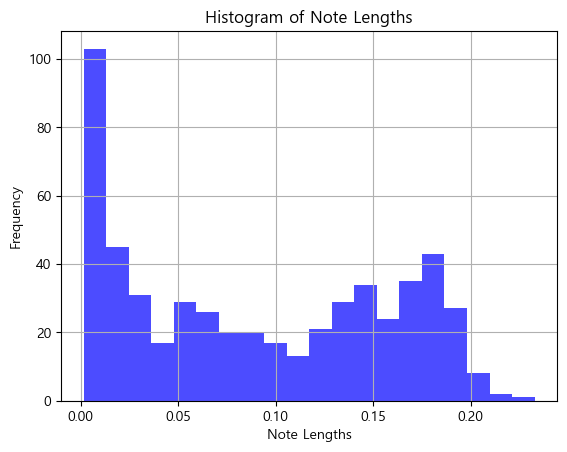

In [69]:
def extract_articulation(filename):
    midi_file = mido.MidiFile(filename)

    notes = []
    current_note = None
    current_note_start = 0

    for msg in midi_file:
        if msg.type == 'note_on':
            if current_note is not None:
                current_note['end_time'] = current_note_start + msg.time
                notes.append(current_note)
            current_note = {'note': msg.note, 'velocity': msg.velocity, 'start_time': msg.time}
            current_note_start = msg.time

    note_lengths = [note['end_time'] - note['start_time'] for note in notes]
    average_note_lengths = sum(note_lengths) / len(note_lengths)
    
    print(average_note_lengths)
    
    legato_marks = 0
    staccato_marks = 0
    tenuto_marks = 0
    fermata_marks = 0

    average_velocity = sum(note['velocity'] for note in notes) / len(notes) if notes else 0
    
    for length in note_lengths:
        velocity = notes[note_lengths.index(length)]['velocity']
        if length <= 0.25 * average_note_lengths and velocity > average_velocity * 1.2:
            staccato_marks += 1
        elif length <= 0.5 * average_note_lengths:
            legato_marks += 1
        elif average_note_lengths < length <= 2 * average_note_lengths:
            tenuto_marks += 1
        elif 2 * average_note_lengths < length <= 3 * average_note_lengths:
            fermata_marks += 1
        else:
            continue     
    
    return {
        "legato": legato_marks,
        "staccato": staccato_marks,
        "tenuto": tenuto_marks,
        "fermata": fermata_marks,
        "note_lengths": note_lengths
    }

filename = './midi_data/piano_datasets/dynamic_perfect.midi'
articulation_info = extract_articulation(filename)
note_length = articulation_info.pop("note_lengths", None)
print("Articulation Info:", articulation_info)

plt.hist(note_length, bins=20, alpha=0.7, color='b')
plt.xlabel('Note Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Note Lengths')
plt.grid(True)
plt.show()

In [70]:
def extract_note_lengths(filename):
    midi_file = mido.MidiFile(filename)

    notes = []
    current_note = None
    current_time = 0

    for msg in midi_file:
        current_time += msg.time
        if msg.type == 'note_on' and msg.velocity > 0:
            if current_note is not None:
                current_note['end_time'] = current_time
                notes.append(current_note)
            current_note = {'note': msg.note, 'velocity': msg.velocity, 'start_time': current_time}

        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            if current_note is not None and msg.note == current_note['note']:
                current_note['end_time'] = current_time
                notes.append(current_note)
                current_note = None

    note_lengths = [note['end_time'] - note['start_time'] for note in notes]
    #for idx, note in enumerate(notes):
    #    print(f'Note {note["note"]}, Length {note_lengths[idx]:.2f}')
    #print('-'*50)

    return note_lengths

def calculate_articulation_similarity(input_lengths, target_lengths):
    #min_length = min(len(input_lengths), len(target_lengths))
    #penalty = len(target_lengths) - len(input_lengths)
    input_lengths = input_lengths[:len(target_lengths)] + [0] * (max(0, len(target_lengths) - len(input_lengths)))
    #target_lengths = target_lengths[:min_length]

    #print(f'Penalty = {penalty}')
    
    input_vector = np.array(input_lengths)
    target_vector = np.array(target_lengths)
    
    dot_product = np.dot(input_vector, target_vector)
    norm_input = np.linalg.norm(input_vector)
    norm_target = np.linalg.norm(target_vector)
    
    if norm_input == 0 or norm_target == 0:
        articulation_similarity = 0.0
    else:
        articulation_similarity = dot_product / (norm_input * norm_target)
    
    #if penalty < 0:
    #    articulation_similarity = articulation_similarity * 100
        # articulation_similarity = articulation_similarity + (penalty * some_weights)
        # 길이가 너무 많이 다르면 -값이 나오는 경우 有
    #else:
    #    articulation_similarity = articulation_similarity * 100
    articulation_similarity = articulation_similarity * 100
    
    return f'{articulation_similarity:.2f}%'

input_lengths = extract_note_lengths("./midi_data/piano_datasets/dynamic_perfect.midi")
target_lengths = extract_note_lengths("./midi_data/piano_datasets/target_data.mid")

articulation_similarity = calculate_articulation_similarity(input_lengths, target_lengths)
print(f"아티큘레이션 유사도: {articulation_similarity}")

아티큘레이션 유사도: 83.79%


In [71]:
test2_input_lengths = [1.5, 2.0, 1.2, 3.0, 2.5, 3.0, 3.0]
test2_target_lengths = [1.2, 1.8, 2.0, 2.5, 3.2]
articulation_similarity = calculate_articulation_similarity(test2_input_lengths, test2_target_lengths)
print(f"아티큘레이션 유사도: {articulation_similarity}")

아티큘레이션 유사도: 96.97%


In [72]:
test3_input_lengths = [1.5, 2.0, 1.2]
test3_target_lengths = [1.2, 1.8, 2.0, 2.5, 3.2]
articulation_similarity = calculate_articulation_similarity(test3_input_lengths, test3_target_lengths)
print(f"아티큘레이션 유사도: {articulation_similarity}")

아티큘레이션 유사도: 56.06%


#### [6.2]. 악센트 정확도

In [73]:
# 기존 코드

def calculate_accent_accuracy(input_data, target_data):
    accent_score = 0

    input_time_range = []
    target_time_range = []

    start = 0
    end = 0
    isAccent = False

    for i in range(len(input_data)):
        # accent on
        if input_data['accent'][i] == 1 and not isAccent:
            start = input_data['sec'][i]
            isAccent = True

        if input_data['accent'][i] == 0 and isAccent:
            end = input_data['sec'][i]
            isAccent = False
            input_time_range.append([start])
            start = 0
            end = 0

    start = 0
    end = 0
    isAccent = False

    for i in range(len(target_data)):
        if target_data['accent'][i] == 1 and not isAccent:
            start = target_data['sec'][i]
            isAccent = True

        if target_data['accent'][i] == 0 and isAccent:
            end = target_data['sec'][i]
            isAccent = False
            target_time_range.append([start])
            start = 0
            end = 0

    if len(target_time_range) == 0:
        return "There's no accent in this song."

    for i in input_time_range:
        if i in target_time_range:
            accent_score += 1

    accent_score = min(100, int(accent_score / len(target_time_range) * 100))
    return f'{accent_score:.2f}%'

accent_accuracy = calculate_accent_accuracy(input_msg_info, target_msg_info)
print(f'악센트 정확도: {accent_accuracy}')

악센트 정확도: 100.00%


In [74]:
# 최종 코드

def calculate_accent_accuracy(input_data, target_data):
    matched_accent_count = 0
    penalty_count = 0

    for i in range(min(len(input_data), len(target_data))):
        if input_data['accent'][i] == target_data['accent'][i]:
            matched_accent_count += 1
        elif target_data['accent'][i] == 1 and input_data['accent'][i] == 0:
            penalty_count += 5
        elif target_data['accent'][i] == 0 and input_data['accent'][i] == 1:
            penalty_count += 3

    max_possible_matches = min(len(input_data), len(target_data))
    adjusted_matched_count = matched_accent_count - penalty_count
    #accent_accuracy = min(100, (adjusted_matched_count / max_possible_matches) * 100)
    accent_accuracy = max(0, min(100, (adjusted_matched_count / max_possible_matches) * 100))
    
    return f'{accent_accuracy:.2f}%'

accent_accuracy = calculate_accent_accuracy(input_msg_info, target_msg_info)
print(f'악센트 정확도: {accent_accuracy}')

악센트 정확도: 100.00%


#### [7]. 리듬


- 리듬을 계산하려면 "틱"을 음악에서 사용되는 시간 단위인 "박자"로 변환 필요

- deltatime: MIDI message가 언제 발생했는지 나타냄

- 틱(Tick): 미디는 각 이벤트의 발생 시간을 틱으로 기록

- 박자(Beat): 음악에서는 박자라는 단위를 사용하여 시간을 나타냄
    - 모든 'note_on' 이벤트를 찾아서 Ticks Per Beat로 나누어 리듬 계산

In [75]:
def extract_rhythm(midi_file):
    midi_file = MidiFile(midi_file)
    ticks_per_beat = midi_file.ticks_per_beat
    time_delta_list = []

    for msg in midi_file:
        if msg.type == 'note_on':
            time_delta_list.append(msg.time / ticks_per_beat)
    
    return time_delta_list

def calculate_rhythm_similarity(input_file_path, target_file_path):
    input_rhythm = extract_rhythm(input_file_path)
    target_rhythm = extract_rhythm(target_file_path)
    
    min_length = min(len(input_rhythm), len(target_rhythm))
    
    input_vector = np.array(input_rhythm[:min_length])
    target_vector = np.array(target_rhythm[:min_length])

    dot_product = np.dot(input_vector, target_vector)
    input_norm = np.linalg.norm(input_vector)
    target_norm = np.linalg.norm(target_vector)
    
    if input_norm == 0 or target_norm == 0:
        return 0
    
    rhythm_similarity = dot_product / (input_norm * target_norm)
    rhythm_similarity *= 100
    
    return f"{rhythm_similarity:.2f}%"

input_file_path = "./midi_data/piano_datasets/dynamic_perfect.midi"
target_file_path = "./midi_data/piano_datasets/target_data.mid"

rhythm_similarity = calculate_rhythm_similarity(input_file_path, target_file_path)
print(f"리듬 유사도: {rhythm_similarity}")

리듬 유사도: 52.13%


In [76]:
# 박자, 노트 길이, 세기 모두 사용

def extract_rhythm(midi_file):
    midi_file = MidiFile(midi_file)
    ticks_per_beat = midi_file.ticks_per_beat
    #print(ticks_per_beat)
    time_delta_list = []
    duration_list = []
    velocity_list = []

    for msg in midi_file:
        if msg.type == 'note_on':
            time_delta_list.append(msg.time / ticks_per_beat)
            duration_list.append(msg.time)
            velocity_list.append(msg.velocity)
    
#     print(time_delta_list)
#     print('-'*30)
#     print(duration_list)
#     print('-'*30)
#     print(velocity_list)
#     print('-'*30)
    return np.array(time_delta_list), np.array(duration_list), np.array(velocity_list)

def calculate_rhythm_similarity(input_file_path, target_file_path):
    input_time_deltas, input_durations, input_velocities = extract_rhythm(input_file_path)
    target_time_deltas, target_durations, target_velocities = extract_rhythm(target_file_path)
    
    min_length = min(len(input_time_deltas), len(target_time_deltas), len(input_durations), len(target_durations), len(input_velocities), len(target_velocities))
    
    input_time_deltas = input_time_deltas[:min_length]
    input_durations = input_durations[:min_length]
    input_velocities = input_velocities[:min_length]
    
    target_time_deltas = target_time_deltas[:min_length]
    target_durations = target_durations[:min_length]
    target_velocities = target_velocities[:min_length]
    
    input_vector = np.concatenate((input_time_deltas, input_durations, input_velocities))
    target_vector = np.concatenate((target_time_deltas, target_durations, target_velocities))

    dot_product = np.dot(input_vector, target_vector)
    input_norm = np.linalg.norm(input_vector)
    target_norm = np.linalg.norm(target_vector)
    
    if input_norm == 0 or target_norm == 0:
        return 0
    
    cosine_similarity = dot_product / (input_norm * target_norm)
    cosine_similarity *= 100
    
    return f"{cosine_similarity:.2f}%"

input_file_path = "./midi_data/piano_datasets/dynamic_perfect.midi"
target_file_path = "./midi_data/piano_datasets/target_data.mid"

rhythm_similarity = calculate_rhythm_similarity(input_file_path, target_file_path)
print(f"리듬 유사도: {rhythm_similarity}")

리듬 유사도: 93.05%


In [77]:
from sklearn.preprocessing import MinMaxScaler

def extract_rhythm(midi_file):
    midi_file = MidiFile(midi_file)
    ticks_per_beat = midi_file.ticks_per_beat
    time_delta_list = []
    duration_list = []
    velocity_list = []

    for msg in midi_file:
        if msg.type == 'note_on':
            time_delta_list.append(msg.time / ticks_per_beat)
            duration_list.append(msg.time)
            velocity_list.append(msg.velocity)
    
    scaler = MinMaxScaler()
    time_delta_list = scaler.fit_transform(np.array(time_delta_list).reshape(-1, 1)).flatten()
    duration_list = scaler.fit_transform(np.array(duration_list).reshape(-1, 1)).flatten()
    velocity_list = scaler.fit_transform(np.array(velocity_list).reshape(-1, 1)).flatten()
    
#     print(time_delta_list)
#     print('-'*30)
#     print(duration_list)
#     print('-'*30)
#     print(velocity_list)
#     print('-'*30)
    return time_delta_list, duration_list, velocity_list

def calculate_rhythm_similarity(input_file_path, target_file_path):
    input_time_deltas, input_durations, input_velocities = extract_rhythm(input_file_path)
    target_time_deltas, target_durations, target_velocities = extract_rhythm(target_file_path)
    
    min_length = min(len(input_time_deltas), len(target_time_deltas), len(input_durations), len(target_durations), len(input_velocities), len(target_velocities))
    
    input_time_deltas = input_time_deltas[:min_length]
    input_durations = input_durations[:min_length]
    input_velocities = input_velocities[:min_length]
    
    target_time_deltas = target_time_deltas[:min_length]
    target_durations = target_durations[:min_length]
    target_velocities = target_velocities[:min_length]
    
    input_vector = np.concatenate((input_time_deltas, input_durations, input_velocities))
    target_vector = np.concatenate((target_time_deltas, target_durations, target_velocities))

    #print(input_vector)
    
    dot_product = np.dot(input_vector, target_vector)
    input_norm = np.linalg.norm(input_vector)
    target_norm = np.linalg.norm(target_vector)
    
    if input_norm == 0 or target_norm == 0:
        return 0
    
    cosine_similarity = dot_product / (input_norm * target_norm)
    cosine_similarity *= 100
    
    return f"{cosine_similarity:.2f}%"

input_file_path = "./midi_data/piano_datasets/dynamic_perfect.midi"
target_file_path = "./midi_data/piano_datasets/target_data.mid"

rhythm_similarity = calculate_rhythm_similarity(input_file_path, target_file_path)
print(f"리듬 유사도: {rhythm_similarity}")


리듬 유사도: 55.26%


- test_input
    - 시간 간격: [0.2, 0.3, 0.4, 0.5]
    - 노트 지속 시간: [60, 70, 80, 90]
    - 노트 세기: [50, 60, 70, 80]

- test_target
    - 시간 간격: [0.25, 0.35, 0.45, 0.55]
    - 노트 지속 시간: [50, 60, 70, 80]
    - 노트 세기: [40, 50, 60, 70]

#### [8]. 페달링

In [78]:
#from sklearn.metrics import accuracy_score

def filter_pedal(pedal_value):
    if isinstance(pedal_value, str) and pedal_value.startswith('['):
        pedal_list = eval(pedal_value)
        return 1 if any(v >= 64 for v in pedal_list) else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    else:
        return 0

def calculate_pedal_accuracy(df_input, df_target): 
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)
    
    print(df_input['pedal'].value_counts())
    print(df_target['pedal'].value_counts())

    #pedal_accuracy = accuracy_score(df_target['pedal'], df_input['pedal'])
    correct = sum(1 for true, pred in zip(df_target['pedal'], df_input['pedal']) if true == pred)
    total = len(df_target)

    penalty_count = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 0  and true == 1)
    penalty_count2 = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 1  and true == 0)
    pedal_accuracy = (correct - 1 * penalty_count - 0.5 * penalty_count2) / total
    #pedal_accuracy = correct / total
    
    return f'{pedal_accuracy * 100:.2f}%'

pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

pedal
0    1047
Name: count, dtype: int64
pedal
0    1047
Name: count, dtype: int64
페달링 정확도: 100.00%


In [79]:
def filter_pedal(pedal_value):
    if isinstance(pedal_value, str):
        if pedal_value.startswith('['):
            pedal_list = eval(pedal_value)
            return 1 if any(v >= 64 for v in pedal_list) else 0
        else:
            pedal_value = int(pedal_value)
            return 1 if pedal_value >= 64 else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    elif isinstance(pedal_value, int):
        return 1 if pedal_value >= 64 else 0
    else:
        return 0

def calculate_pedal_accuracy(df_input, df_target): 
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)
    
    print("df_input pedal values after filtering:")
    print(df_input['pedal'].value_counts())
    print("df_target pedal values after filtering:")
    print(df_target['pedal'].value_counts())

    correct = sum(1 for true, pred in zip(df_target['pedal'], df_input['pedal']) if true == pred)
    total = len(df_target)

    penalty_count = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 0 and true == 1)
    penalty_count2 = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 1 and true == 0)
    pedal_accuracy = (correct - 1 * penalty_count - 0.5 * penalty_count2) / total
    
    return f'{pedal_accuracy * 100:.2f}%'

pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

df_input pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
df_target pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
페달링 정확도: 100.00%


In [80]:
def calculate_pedal_accuracy(df_input, df_target): 
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)
    
    print("df_input pedal values after filtering:")
    print(df_input['pedal'].value_counts())
    print("df_target pedal values after filtering:")
    print(df_target['pedal'].value_counts())

    correct = sum(1 for true, pred in zip(df_target['pedal'], df_input['pedal']) if true == pred)
    total = len(df_target)

    penalty_count = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 0 and true == 1)
    penalty_count2 = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 1 and true == 0)
    pedal_accuracy = (correct - 1 * penalty_count - 0.5 * penalty_count2) / total
    
    def save_dataframe_with_increment(df, filename):
        base, ext = os.path.splitext(filename)
        counter = 0
        new_filename = filename
        while os.path.exists(new_filename):
            counter += 1
            new_filename = f"{base}_{counter}{ext}"
        df.to_csv(new_filename, index=False)
        print(f"DataFrame saved as {new_filename}")

    save_dataframe_with_increment(df_input, 'result_pedal.csv')
    save_dataframe_with_increment(df_target, 'target_pedal.csv')
    
    return f'{pedal_accuracy * 100:.2f}%'

In [81]:
def calculate_pedal_accuracy(df_input, df_target): 
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)
    
    print("df_input pedal values after filtering:")
    print(df_input['pedal'].value_counts())
    print("df_target pedal values after filtering:")
    print(df_target['pedal'].value_counts())

    correct = sum(1 for true, pred in zip(df_target['pedal'], df_input['pedal']) if true == pred)
    total = len(df_target)

    penalty_count = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 0 and true == 1)
    penalty_count2 = sum(1 for pred, true in zip(df_input['pedal'], df_target['pedal']) if pred == 1 and true == 0)
    pedal_accuracy = (correct - 1 * penalty_count - 0.5 * penalty_count2) / total
    
    return f'{pedal_accuracy * 100:.2f}%'

pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

df_input pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
df_target pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
페달링 정확도: 100.00%


In [82]:
def calculate_pedal_accuracy(df_input, df_target):
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)

    print("df_input pedal values after filtering:")
    print(df_input['pedal'].value_counts())
    print("df_target pedal values after filtering:")
    print(df_target['pedal'].value_counts())

    input_pedals = df_input['pedal'].tolist()
    target_pedals = df_target['pedal'].tolist()

    input_chunks = [input_pedals[i:i + 30] for i in range(0, len(input_pedals), 30)]
    target_chunks = [target_pedals[i:i + 30] for i in range(0, len(target_pedals), 30)]

    correct_chunks = 0
    total_chunks = 0
    penalty_count = 0
    penalty_count2 = 0

    for input_chunk, target_chunk in zip(input_chunks, target_chunks):
        if not input_chunk or not target_chunk:
            continue

        total_chunks += 1
        print(input_chunk)
        print(target_chunk)
        print('-'*30)
        correct = sum(1 for true, pred in zip(target_chunk, input_chunk) if true == pred)
        penalty_count += sum(1 for pred, true in zip(input_chunk, target_chunk) if pred == 0 and true == 1)
        penalty_count2 += sum(1 for pred, true in zip(input_chunk, target_chunk) if pred == 1 and true == 0)

        chunk_accuracy = correct - 1 * penalty_count - 0.5 * penalty_count2
        correct_chunks += chunk_accuracy

    if total_chunks == 0:
        return "0.00%"
    else:
        pedal_accuracy = (correct_chunks - penalty_count - 0.5 * penalty_count2) / (total_chunks * 30) * 100
        return f'{pedal_accuracy:.2f}%'
    
pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

df_input pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
df_target pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [83]:
def calculate_pedal_accuracy(df_input, df_target):
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)

    print("df_input pedal values after filtering:")
    print(df_input['pedal'].value_counts())
    print("df_target pedal values after filtering:")
    print(df_target['pedal'].value_counts())

    input_pedals = df_input['pedal'].tolist()
    target_pedals = df_target['pedal'].tolist()

    input_chunks = [input_pedals[i:i + 30] for i in range(0, len(input_pedals), 30)]
    target_chunks = [target_pedals[i:i + 30] for i in range(0, len(target_pedals), 30)]

    correct_chunks = 0
    total_chunks = min(len(input_chunks), len(target_chunks))
    penalty_count = 0
    penalty_count2 = 0

    for i in range(total_chunks):
        input_chunk = input_chunks[i]
        target_chunk = target_chunks[i]
        best_score = 0

        print(f"\nComparing chunk {i+1}")
        print(f"Target chunk: {target_chunk}")
        print(f"Input chunk: {input_chunk}")

        if input_chunk == target_chunk:
            best_score = 1.5  # 완전 일치
        elif any(item == 1 for item in target_chunk) and all(item in input_chunk for item in target_chunk if item != 0):
            best_score = 0.9  # 부분 포함

        correct_chunks += best_score

        # Calculate penalties
        if all(item == 0 for item in target_chunk) and any(item == 1 for item in input_chunk):
            penalty_count += 1

        if any(item == 1 for item in target_chunk) and not any(item == 1 for item in input_chunk):
            penalty_count2 += 1

        print(f"Best score for chunk {i+1}: {best_score}")
        print(f"Penalty count: {penalty_count}, Penalty count2: {penalty_count2}")

    print('최종 스코어')
    print(f"correct_chunks: {correct_chunks}")
    print(f"Penalty count: {penalty_count}, Penalty count2: {penalty_count2}")
    pedal_accuracy = (correct_chunks - 0.7 * penalty_count - 1.4 * penalty_count2) / total_chunks * 100
    pedal_accuracy = max(0, min(100, pedal_accuracy))  # Ensure the accuracy is between 0 and 100

    return f'{pedal_accuracy:.2f}%'
    
pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

df_input pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64
df_target pedal values after filtering:
pedal
0    1012
1      35
Name: count, dtype: int64

Comparing chunk 1
Target chunk: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input chunk: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Best score for chunk 1: 1.5
Penalty count: 0, Penalty count2: 0

Comparing chunk 2
Target chunk: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input chunk: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Best score for chunk 2: 1.5
Penalty count: 0, Penalty count2: 0

Comparing chunk 3
Target chunk: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input chunk: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Best 

In [84]:
# 페달링 최종 최종 최종
def filter_pedal(pedal_value):
    if isinstance(pedal_value, str):
        if pedal_value.startswith('['):
            pedal_list = eval(pedal_value)
            return 1 if any(v >= 64 for v in pedal_list) else 0
        else:
            pedal_value = int(pedal_value)
            return 1 if pedal_value >= 64 else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    elif isinstance(pedal_value, int):
        return 1 if pedal_value >= 64 else 0
    else:
        return 0

def calculate_pedal_accuracy(df_input, df_target):
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)

    # print("df_input pedal values after filtering:")
    # print(df_input['pedal'].value_counts())
    # print("df_target pedal values after filtering:")
    # print(df_target['pedal'].value_counts())

    input_pedals = df_input['pedal'].tolist()
    target_pedals = df_target['pedal'].tolist()

    input_chunks = [input_pedals[i:i + 30] for i in range(0, len(input_pedals), 30)]
    target_chunks = [target_pedals[i:i + 30] for i in range(0, len(target_pedals), 30)]

    correct_chunks = 0
    total_chunks = min(len(input_chunks), len(target_chunks))
    penalty_count = 0
    penalty_count2 = 0

    for i in range(total_chunks):
        input_chunk = input_chunks[i]
        target_chunk = target_chunks[i]
        best_score = 0

        #print(f"\nComparing chunk {i+1}")
        #print(f"Target chunk: {target_chunk}")
        #print(f"Input chunk: {input_chunk}")

        # Calculate penalties
        if all(item == 0 for item in target_chunk) and any(item == 1 for item in input_chunk):
            penalty_count += 1

        if any(item == 1 for item in target_chunk) and not any(item == 1 for item in input_chunk):
            penalty_count2 += 1

        #print(f"Penalty count: {penalty_count}, Penalty count2: {penalty_count2}")

    #print('최종 스코어')
    #print(f"Penalty count: {penalty_count}, Penalty count2: {penalty_count2}")
    pedal_accuracy = (100 - 1 * penalty_count - 1.6 * penalty_count2)
    pedal_accuracy = max(0, min(100, pedal_accuracy))  # Ensure the accuracy is between 0 and 100

    return f'{pedal_accuracy:.2f}%'
    
pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

페달링 정확도: 100.00%


In [85]:
def filter_pedal(pedal_value):
    if isinstance(pedal_value, str):
        if pedal_value.startswith('['):
            pedal_list = eval(pedal_value)
            return 1 if any(v >= 64 for v in pedal_list) else 0
        else:
            pedal_value = int(pedal_value)
            return 1 if pedal_value >= 64 else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    elif isinstance(pedal_value, int):
        return 1 if pedal_value >= 64 else 0
    else:
        return 0

def calculate_pedal_accuracy(df_input, df_target):
    common_indices = df_input.index.intersection(df_target.index)
    df_input = df_input.loc[common_indices].reset_index(drop=True)
    df_target = df_target.loc[common_indices].reset_index(drop=True)

    df_input['pedal'] = df_input['pedal'].apply(filter_pedal)
    df_target['pedal'] = df_target['pedal'].apply(filter_pedal)

    input_pedals = df_input['pedal'].tolist()
    target_pedals = df_target['pedal'].tolist()

    input_chunks = [input_pedals[i:i + 100] for i in range(0, len(input_pedals), 100)]
    target_chunks = [target_pedals[i:i + 100] for i in range(0, len(target_pedals), 100)]

    total_chunks = min(len(input_chunks), len(target_chunks))
    chunk_scores = []

    for chunk_index in range(total_chunks):
        input_chunk = input_chunks[chunk_index]
        target_chunk = target_chunks[chunk_index]
        chunk_penalties = 0

        input_subchunks = [input_chunk[i:i + 10] for i in range(0, len(input_chunk), 10)]
        target_subchunks = [target_chunk[i:i + 10] for i in range(0, len(target_chunk), 10)]

        for subchunk_index, (input_subchunk, target_subchunk) in enumerate(zip(input_subchunks, target_subchunks)):
            if len(input_subchunk) != len(target_subchunk):
                continue

            if all(item == 0 for item in target_subchunk) and any(item == 1 for item in input_subchunk):
                penalty = 1.2
            elif any(item == 1 for item in target_subchunk) and not any(item == 1 for item in input_subchunk):
                penalty = 2.4
            else:
                penalty = 0

            chunk_penalties += penalty

            #print(f"청크 {chunk_index + 1}의 서브 청크 {subchunk_index + 1} 비교: 입력값 {input_subchunk} vs 목표값 {target_subchunk}, "
            #      f"패널티: {penalty:.2f}")

        chunk_score = max(100 - chunk_penalties, 0)
        chunk_scores.append(chunk_score)

        #print(f"청크 {chunk_index + 1} 전체 점수: {chunk_score:.2f}%")

    if not chunk_scores:
        return "0.00%"

    # 절사평균 계산 (최소 점수와 최대 점수 제외)
    #if len(chunk_scores) > 2:
    #    chunk_scores.remove(max(chunk_scores))
    #    chunk_scores.remove(min(chunk_scores))

    pedal_accuracy = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0

    return f'{pedal_accuracy:.2f}%'
    
pedal_accuracy = calculate_pedal_accuracy(input_msg_info, target_msg_info)
print(f'페달링 정확도: {pedal_accuracy}')

페달링 정확도: 100.00%


### Ⅴ. 성능 테스트

In [86]:
def performance_evaluate(df_input, df_target):
    # 1. 노트 정확도
    note_accuracy = calculate_note_accuracy(df_input, df_target)
    print(f'[1]. 음정 정확도: {note_accuracy}')

    # 2. 셈여림 정확도
    dynamic_accuracy = calculate_dynamic_accuracy(df_input, df_target)
    print(f'[2]. 셈여림 정확도: {dynamic_accuracy}')
    
    # 3. 셈여림 변화 일관성
    dynamic_change_score = calculate_dynamic_change_consistency(df_input, df_target)
    print(f'[3]. 셈여림 변화 일관성: {dynamic_change_score}')

    # 4. 곡의 빠르기 유사도 - 현재 구현 어려움
    # 5. 곡의 빠르기 변화 - 현재 구현 어려움
    
    # 6. 아티큘레이션
    # 6.1. 붙임줄, 스타카토, 테누토, 늘임표
    input_lengths = extract_note_lengths(data_folder + '/' + input_name)
    target_lengths = extract_note_lengths(data_folder + '/' + target_name)

    articulation_similarity = calculate_articulation_similarity(input_lengths, target_lengths)

    print(f'[6.1]. 아티큘레이션 유사도: {articulation_similarity}')
    
    # 6.2. 악센트 정확도
    accent_accuracy = calculate_accent_accuracy(df_input, df_target)
    print(f'[6.2]. 악센트 정확도: {accent_accuracy}')
    
    # 7. 리듬 유사도
    rhythm_similarity = calculate_rhythm_similarity(data_folder + '/' + input_name, data_folder + '/' + target_name)
    print(f'[7]. 리듬 유사도: {rhythm_similarity}')
    
    # 8. 페달링 정확도
    pedal_accuracy = calculate_pedal_accuracy(df_input, df_target)
    print(f'[8]. 페달링 정확도: {pedal_accuracy}')

In [87]:
sec_base = True
seq_base = True

sec_unit  = 0.1

In [88]:
def mid_test_performance(input_name, target_name):
    input_mid, target_mid = load_midi_data(input_name, target_name)
    
    if pre_check(input_mid, target_mid):
        print("===== pre_check success =====")
        input_info, target_info = extrack_mid_info(input_mid, target_mid)
        input_info, target_info = align_and_save_dataframes(input_mid, target_mid)
        
    else:
        print("===== pre_check failed =====")
        input_info, target_info = extrack_mid_info(input_mid, target_mid)
        input_info, target_info = align_and_save_dataframes(input_mid, target_mid)
        #return
    
    input_msg_info, target_msg_info = load_mid_Info_from_csv(input_mid, target_mid)
    
    # 성능 테스트
    performance_evaluate(input_msg_info, target_msg_info)

#### [1]. 04/11 piano datasets

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "note_bad.midi"
target_name = "target_data.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "note_bad2.midi"
target_name = "target_data.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "note_perfect.midi"
target_name = "target_data.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "note_perfect2.midi"
target_name = "target_data.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "dynamic_perfect.midi"
target_name = "dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "dynamic_perfect2.midi"
target_name = "dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "dynamic_half_perfect.midi"
target_name = "dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/piano_datasets"

input_name  = "dynamic_half_perfect2.midi"
target_name = "dynamic_target.midi"

mid_test_performance(input_name, target_name)

#### [2]. 06/18 piano datasets

##### 2.1. bach

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_note_perfect1.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_note_perfect2.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_note_bad1.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_note_bad2.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "new_dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "new_dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_bad1.midi"
target_name = "new_dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_bad2.midi"
target_name = "new_dynamic_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_bad1.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_dynamic_bad2.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_pedal_perfect.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_pedal_bad.midi"
target_name = "new_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/bach"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_target.midi"

mid_test_performance(input_name, target_name)

##### 2.2. beethoven

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_note_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_note_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_note_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_note_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_dynamic_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_dynamic_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_dynamic_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_dynamic_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/20240618_piano_dataset/beethoven"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### [3]. 07/24 piano datasets
- 아래 순서로 작업
- note perfect, note bad
- dynamic perfect, dynamic bad
- pedal perfect, pedal bad

### 3.1 bach

#### note - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

#### note - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_note_perfect1.mid"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_note_perfect2.mid"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_note_bad1.mid"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_note_bad2.mid"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

#### dynamic - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_dynamic_perfect1.mid"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_dynamic_perfect2.mid"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_dynamic_bad1.mid"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_dynamic_bad2.mid"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jinhee_bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_pedal_perfect.mid"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/bach"

input_name  = "jihyun_bach_pedal_bad.mid"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

### 3.2 beethoven

#### note - jihhee

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_note_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_note_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_note_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_note_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### note - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_note_perfect1.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_note_perfect2.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_note_bad1.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_note_bad2.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### dynamic - jihhee

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_dynamic_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_dynamic_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_dynamic_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_dynamic_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### dynamic - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_dynamic_perfect1.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_dynamic_perfect2.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_dynamic_bad1.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_pedal_bad.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### pedal - jihhee

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jinhee_beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

#### pedal - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_pedal_perfect.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/beethoven"

input_name  = "jihyun_beethoven_pedal_bad.mid"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

### 3.3 chopin

#### note - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_note_perfect1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_note_perfect2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_note_bad1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_note_bad2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

#### note - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_note_perfect1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_note_perfect2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_note_bad1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_note_bad2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_dynamic_perfect1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_dynamic_perfect2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_dynamic_bad1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_dynamic_bad2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_dynamic_perfect1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_dynamic_perfect2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_dynamic_bad1.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_dynamic_bad2.mid"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jinhee_chopin_pedal_bad.mid"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_pedal_perfect.mid"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin"

input_name  = "jihyun_chopin_pedal_bad.mid"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

### 3.4 chopin prelude

#### note - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_note_perfect1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_note_perfect1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_note_perfect2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_note_bad1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_note_bad2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

#### note - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_note_perfect1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_note_perfect2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_note_bad1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_note_bad2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_dynamic_perfect1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_dynamic_perfect2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_dynamic_bad1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_dynamic_bad2.mid"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_dynamic_perfect1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_dynamic_perfect2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_dynamic_bad1.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_dynamic_bad2.mid"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

#### pedal - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_pedal_perfect.mid"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jinhee_chopin_prelude_pedal_bad.mid"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_pedal_perfect.mid"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/chopin_prelude"

input_name  = "jihyun_chopin_prelude_pedal_bad.mid"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

### 3.5 mozart

#### note - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_note_perfect1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_note_perfect2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_note_bad1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_note_bad2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

#### note - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_note_perfect1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_note_perfect2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_note_bad1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_note_bad2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_dynamic_perfect1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_dynamic_perfect2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_dynamic_bad1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_dynamic_bad2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

#### dynamic - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_dynamic_perfect1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_dynamic_perfect2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_dynamic_bad1.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_dynamic_bad2.mid"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jinhee

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_pedal_perfect.mid"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jinhee_mozart_pedal_bad.mid"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

#### pedal - jihyun

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_pedal_perfect.mid"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/0724_dataset/mozart"

input_name  = "jihyun_mozart_pedal_bad.mid"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

# Bach

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jeo"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jungwook"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jihyun"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/bach/jinhee"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

# Beethoven

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_note_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_note_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_note_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_note_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_dynamic_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_dynamic_perfect3.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_dynamic_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_dynamic_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jeo"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_note_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_note_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_note_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_note_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_dynamic_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_dynamic_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_dynamic_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_dynamic_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jungwook"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_note_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_note_perfect (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_note_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_note_bad (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_dynamic_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_dynamic_perfect (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_dynamic_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_dynamic_bad (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jihyun"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

---

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_note_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_note_perfect (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_note_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_note_bad (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_dynamic_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_dynamic_perfect (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_dynamic_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_dynamic_bad (D).midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/beethoven/jinhee"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

---

# chopin

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_note_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_note_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_note_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_note_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_dynamic_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_dynamic_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_dynamic_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_dynamic_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_pedal_perfect.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jeo"

input_name  = "chopin_pedal_bad.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_note_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_note_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_note_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_note_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_dynamic_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_dynamic_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_dynamic_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_dynamic_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_pedal_perfect.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jungwook"

input_name  = "chopin_pedal_bad.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_note_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_note_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_note_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_note_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_dynamic_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_dynamic_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_dynamic_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_dynamic_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_pedal_perfect.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jihyun"

input_name  = "chopin_pedal_bad.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_note_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_note_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_note_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_note_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_dynamic_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_dynamic_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_dynamic_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_dynamic_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_pedal_perfect.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin/jinhee"

input_name  = "chopin_pedal_bad.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

# chopin_prelude

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_left_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

# mozart

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_note_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_note_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_note_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_note_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_dynamic_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_dynamic_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_dynamic_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_dynamic_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_pedal_perfect.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jeo"

input_name  = "mozart_pedal_bad.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_note_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_note_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_note_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_note_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_dynamic_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_dynamic_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_dynamic_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_dynamic_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_pedal_perfect.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jungwook"

input_name  = "mozart_pedal_bad.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_note_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_note_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_note_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_note_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_dynamic_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_dynamic_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_dynamic_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_dynamic_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_pedal_perfect.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jihyun"

input_name  = "mozart_pedal_bad.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_note_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_note_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_note_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_note_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_dynamic_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_dynamic_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_dynamic_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_dynamic_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_pedal_perfect.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/mozart/jinhee"

input_name  = "mozart_pedal_bad.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

# chopin_prelude (Right)

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target_right_only.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

# chopin_prelude (all)

## ▶ jeo

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jeo"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jungwook

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jungwook"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jihyun

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jihyun"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

## ▶ jinhee

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

In [ ]:
data_folder = "midi_data/1018_dataset/chopin_prelude/jinhee"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

---

---

## ▶ hyunsung

### bach

In [90]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_note_perfect1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_perfect1.midi
총 재생 시간:  104.96406250000001
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. note_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_target.midi
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'note_perfect1']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[64],[30],ppp,0,1,100,0,0,125
1,0.1,[note_on],[0],[67],[38],pp,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[72],[35],ppp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[61],p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[44],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 75.34%
[2]. 셈여림 정확도: 87.40%
[3]. 셈여림 변화 일관성: 15.95%
[6.1]. 아티큘레이션 유사도: 62.12%
[6.2]. 악센트 정확도: 94.13%
[7]. 리듬 유사도: 52.06%
[8]. 페달링 정확도: 96.49%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [91]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_note_perfect2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_perfect2.midi
총 재생 시간:  104.93593750000001
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. note_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_target.midi
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'note_perfect2']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on]","[0, 0]","[60, 64]","[42, 27]",ppp,0,2,100,0,0,125
1,0.1,[],[],[],[],,0,0,0,0,"[122, 108, 96, 82]",0
2,0.2,[note_on],[0],[67],[27],ppp,0,1,0,0,"[66, 54, 42, 32, 22, 12, 2, 0]",0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[note_on],[0],[72],[44],pp,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[61],p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[44],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 75.34%
[2]. 셈여림 정확도: 87.27%
[3]. 셈여림 변화 일관성: 15.12%
[6.1]. 아티큘레이션 유사도: 61.98%
[6.2]. 악센트 정확도: 93.46%
[7]. 리듬 유사도: 49.66%
[8]. 페달링 정확도: 96.89%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [92]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_note_bad1.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_bad1.midi
총 재생 시간:  104.6421875
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. note_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_target.midi
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'note_bad']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'Piano'])
=

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on]","[0, 0]","[62, 64]","[32, 26]",ppp,0,2,100,0,"[122, 104]",119
1,0.1,[note_on],[0],[67],[30],ppp,0,1,0,0,"[86, 65, 48, 30, 12, 0]",0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[72],[42],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1041,104.1,[],[],[],[],,0,0,0,0,0,0
1042,104.2,[],[],[],[],,0,0,0,0,0,0
1043,104.3,[],[],[],[],,0,0,0,0,0,0
1044,104.4,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[61],p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[44],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1046, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 73.04%
[2]. 셈여림 정확도: 83.93%
[3]. 셈여림 변화 일관성: 12.00%
[6.1]. 아티큘레이션 유사도: 62.30%
[6.2]. 악센트 정확도: 84.28%
[7]. 리듬 유사도: 40.60%
[8]. 페달링 정확도: 96.58%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [93]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_note_bad2.midi"
target_name = "bach_note_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_bad2.midi
총 재생 시간:  104.953125
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. note_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_note_target.midi
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'note_bad2']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'Piano'])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[59],[46],pp,0,1,100,0,42,119
1,0.1,[note_on],[0],[60],[18],ppp,0,1,0,0,"[48, 52, 54, 56, 58, 60]",0
2,0.2,[],[],[],[],,0,0,0,0,"[58, 56, 52]",0
3,0.3,"[note_on, note_on]","[0, 0]","[64, 65]","[26, 18]",ppp,0,2,0,0,"[42, 36, 12, 0]",0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[61],p,0,1,"[100, 100, 100]","[127, 127]",127,"[64, 64]"
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[44],pp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 70.81%
[2]. 셈여림 정확도: 85.33%
[3]. 셈여림 변화 일관성: 13.54%
[6.1]. 아티큘레이션 유사도: 61.35%
[6.2]. 악센트 정확도: 91.05%
[7]. 리듬 유사도: 44.94%
[8]. 페달링 정확도: 96.67%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [94]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_dynamic_perfect1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_perfect1.midi
총 재생 시간:  104.97187500000001
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. dynamic_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano right
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'dynamic_perfect1']) != target track name(['Das wohltemperierte Klavier I - Praeludium und

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[19],ppp,0,1,100,0,0,119
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[note_on],[0],[64],[10],ppp,0,1,0,0,0,0
3,0.3,[note_on],[0],[67],[27],ppp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 62]",127,0,"[64, 28]"
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[53],p,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2642,264.2,[],[],[],[],,0,0,0,0,0,0
2643,264.3,[],[],[],[],,0,0,0,0,0,0
2644,264.4,[],[],[],[],,0,0,0,0,0,0
2645,264.5,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2647, 12)
[1]. 음정 정확도: 77.84%
[2]. 셈여림 정확도: 90.87%
[3]. 셈여림 변화 일관성: 15.91%
[6.1]. 아티큘레이션 유사도: 60.25%
[6.2]. 악센트 정확도: 69.78%
[7]. 리듬 유사도: 42.91%
[8]. 페달링 정확도: 98.31%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [95]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_dynamic_perfect2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_perfect2.midi
총 재생 시간:  104.90468750000001
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. dynamic_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano right
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'dynamic_perfect2']) != target track name(['Das wohltemperierte Klavier I - Praeludium und

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[34],ppp,0,1,100,0,0,119
1,0.1,[note_on],[0],[64],[21],ppp,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[21],ppp,0,1,0,0,6,0
4,0.4,[],[],[],[],,0,0,0,0,"[14, 20, 28, 30, 36, 42, 44, 46, 48]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 62]",127,0,"[64, 28]"
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[53],p,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2642,264.2,[],[],[],[],,0,0,0,0,0,0
2643,264.3,[],[],[],[],,0,0,0,0,0,0
2644,264.4,[],[],[],[],,0,0,0,0,0,0
2645,264.5,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2647, 12)
[1]. 음정 정확도: 77.76%
[2]. 셈여림 정확도: 90.47%
[3]. 셈여림 변화 일관성: 16.52%
[6.1]. 아티큘레이션 유사도: 60.25%
[6.2]. 악센트 정확도: 73.40%
[7]. 리듬 유사도: 45.43%
[8]. 페달링 정확도: 96.53%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [96]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_dynamic_bad1.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_bad1.midi
총 재생 시간:  104.91718750000001
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. dynamic_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano right
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'dynamic_bad1']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,119
1,0.1,[note_on],[0],[60],[93],f,1,1,0,0,70,0
2,0.2,[],[],[],[],,0,0,0,0,"[60, 50, 38, 10, 0]",0
3,0.3,[note_on],[0],[64],[57],p,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 62]",127,0,"[64, 28]"
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[53],p,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2642,264.2,[],[],[],[],,0,0,0,0,0,0
2643,264.3,[],[],[],[],,0,0,0,0,0,0
2644,264.4,[],[],[],[],,0,0,0,0,0,0
2645,264.5,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2647, 12)
[1]. 음정 정확도: 77.65%
[2]. 셈여림 정확도: 89.40%
[3]. 셈여림 변화 일관성: 15.99%
[6.1]. 아티큘레이션 유사도: 58.41%
[6.2]. 악센트 정확도: 59.50%
[7]. 리듬 유사도: 53.34%
[8]. 페달링 정확도: 97.60%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [97]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_dynamic_bad2.midi"
target_name = "bach_dynamic_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_bad2.midi
총 재생 시간:  104.890625
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. dynamic_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_dynamic_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano right
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'dynamic_bad2']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[81],mf,1,1,100,0,0,119
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[note_on],[0],[64],[59],p,0,1,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[note_on],[0],[67],[84],mf,1,1,0,0,127,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1043,104.3,[],[],[],[],,0,0,0,0,0,0
1044,104.4,[],[],[],[],,0,0,0,0,"[14, 50, 65, 76, 88, 98]",0
1045,104.5,[],[],[],[],,0,0,0,0,"[106, 116, 124, 127]",0
1046,104.6,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 62]",127,0,"[64, 28]"
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[67],[53],p,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2642,264.2,[],[],[],[],,0,0,0,0,0,0
2643,264.3,[],[],[],[],,0,0,0,0,0,0
2644,264.4,[],[],[],[],,0,0,0,0,0,0
2645,264.5,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1048, 12)
Target shape: (2647, 12)
[1]. 음정 정확도: 77.76%
[2]. 셈여림 정확도: 89.47%
[3]. 셈여림 변화 일관성: 16.14%
[6.1]. 아티큘레이션 유사도: 61.02%
[6.2]. 악센트 정확도: 51.57%
[7]. 리듬 유사도: 43.33%
[8]. 페달링 정확도: 97.64%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [98]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_pedal_perfect.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_pedal_perfect.midi
총 재생 시간:  104.9109375
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. pedal_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_pedal_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano left
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'pedal_perfect']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BW

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[note_on],[0],[60],[31],ppp,0,1,100,0,0,119
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[note_on],[0],[64],[15],ppp,0,1,0,0,0,0
3,0.3,[note_on],[0],[67],[25],ppp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,74,0
1046,104.6,[],[],[],[],,0,0,0,0,"[76, 78, 80, 82]",0
1047,104.7,[],[],[],[],,0,0,0,0,"[84, 86, 88, 90, 94, 96]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,27,0,0,0
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 74.84%
[2]. 셈여림 정확도: 98.18%
[3]. 셈여림 변화 일관성: 9.74%
[6.1]. 아티큘레이션 유사도: 71.02%
[6.2]. 악센트 정확도: 100.00%
[7]. 리듬 유사도: 44.46%
[8]. 페달링 정확도: 97.73%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [99]:
data_folder = "midi_data/1104_dataset/bach"

input_name  = "bach_pedal_bad.midi"
target_name = "bach_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_pedal_bad.midi
총 재생 시간:  104.934375
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. pedal_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/bach\bach_pedal_target.mid
총 재생 시간:  117.09194183333332
----------------------------------------------------------------------
트랙 이름:  Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
총 트랙의 수:  2
[1]. Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846
[2]. Piano left
input track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'pedal_bad']) != target track name(['Das wohltemperierte Klavier I - Praeludium und Fuge 1 in C-Dur BWV 846', 'Pian

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,119
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[note_on],[0],[60],[62],mp,0,1,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1044,104.4,[],[],[],[],,0,0,0,0,0,0
1045,104.5,[],[],[],[],,0,0,0,0,0,0
1046,104.6,[],[],[],[],,0,0,0,0,0,0
1047,104.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,27,0,0,0
1,0.1,[note_on],[0],[64],[57],p,0,1,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,265.4,[],[],[],[],,0,0,0,0,0,0
2655,265.5,[],[],[],[],,0,0,0,0,0,0
2656,265.6,[],[],[],[],,0,0,0,0,0,0
2657,265.7,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1049, 12)
Target shape: (2659, 12)
[1]. 음정 정확도: 74.59%
[2]. 셈여림 정확도: 97.64%
[3]. 셈여림 변화 일관성: 9.89%
[6.1]. 아티큘레이션 유사도: 69.83%
[6.2]. 악센트 정확도: 100.00%
[7]. 리듬 유사도: 66.24%
[8]. 페달링 정확도: 95.82%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


---

### beethoven

In [107]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_note_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_note_perfect1.midi
총 재생 시간:  99.55250000000001
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. note_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'note_perfect1']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,[],[],[],[],,0,0,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (995, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 95.81%
[2]. 셈여림 정확도: 73.38%
[3]. 셈여림 변화 일관성: 65.29%
[6.1]. 아티큘레이션 유사도: 66.48%
[6.2]. 악센트 정확도: 48.34%
[7]. 리듬 유사도: 84.57%
[8]. 페달링 정확도: 85.12%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [108]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_note_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_note_perfect2.midi
총 재생 시간:  99.485
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. note_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'note_perfect2']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
989,98.9,"[note_on, note_on, note_on]","[0, 0, 0]","[72, 66, 69]","[15, 18, 21]",ppp,0,3,0,0,0,0
990,99.0,[],[],[],[],,0,0,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (994, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 95.30%
[2]. 셈여림 정확도: 76.12%
[3]. 셈여림 변화 일관성: 65.49%
[6.1]. 아티큘레이션 유사도: 53.06%
[6.2]. 악센트 정확도: 45.33%
[7]. 리듬 유사도: 80.57%
[8]. 페달링 정확도: 85.12%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [109]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_note_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_note_bad1.midi
총 재생 시간:  99.345
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. note_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'note_bad1']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
988,98.8,[],[],[],[],,0,0,0,0,0,0
989,98.9,[],[],[],[],,0,0,0,0,0,0
990,99.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[60, 72, 66, 69, 63]","[42, 28, 43, 28, 19]",ppp,0,5,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (993, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 71.55%
[2]. 셈여림 정확도: 73.75%
[3]. 셈여림 변화 일관성: 70.32%
[6.1]. 아티큘레이션 유사도: 55.77%
[6.2]. 악센트 정확도: 42.11%
[7]. 리듬 유사도: 80.92%
[8]. 페달링 정확도: 85.12%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [110]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_note_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_note_bad2.midi
총 재생 시간:  99.33500000000001
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. note_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'note_bad2']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
988,98.8,[],[],[],[],,0,0,0,0,0,0
989,98.9,[],[],[],[],,0,0,0,0,0,0
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[64, 60, 57]","[77, 70, 66]",mp,0,3,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (993, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 62.40%
[2]. 셈여림 정확도: 71.50%
[3]. 셈여림 변화 일관성: 63.98%
[6.1]. 아티큘레이션 유사도: 49.13%
[6.2]. 악센트 정확도: 32.06%
[7]. 리듬 유사도: 80.98%
[8]. 페달링 정확도: 85.12%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [111]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_dynamic_perfect1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_dynamic_perfect1.midi
총 재생 시간:  99.43375
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. dynamic_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'dynamic_perfect1']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
989,98.9,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 72, 69]","[20, 19, 23]",ppp,0,3,0,0,0,0
990,99.0,[],[],[],[],,0,0,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (994, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 96.21%
[2]. 셈여림 정확도: 79.25%
[3]. 셈여림 변화 일관성: 65.59%
[6.1]. 아티큘레이션 유사도: 67.19%
[6.2]. 악센트 정확도: 46.13%
[7]. 리듬 유사도: 84.02%
[8]. 페달링 정확도: 87.64%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [112]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_dynamic_perfect2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_dynamic_perfect2.midi
총 재생 시간:  99.51625
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. dynamic_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'dynamic_perfect2']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on]","[0, 0]","[72, 69]","[14, 15]",ppp,0,2,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (995, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 96.45%
[2]. 셈여림 정확도: 76.62%
[3]. 셈여림 변화 일관성: 62.47%
[6.1]. 아티큘레이션 유사도: 57.79%
[6.2]. 악센트 정확도: 41.91%
[7]. 리듬 유사도: 84.34%
[8]. 페달링 정확도: 89.92%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [113]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_dynamic_bad1.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_dynamic_bad1.midi
총 재생 시간:  99.49875
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. dynamic_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'dynamic_bad1']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
989,98.9,[],[],[],[],,0,0,0,0,0,0
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 72, 69]","[18, 26, 23]",ppp,0,3,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (994, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 94.95%
[2]. 셈여림 정확도: 57.62%
[3]. 셈여림 변화 일관성: 66.10%
[6.1]. 아티큘레이션 유사도: 53.60%
[6.2]. 악센트 정확도: 10.95%
[7]. 리듬 유사도: 72.61%
[8]. 페달링 정확도: 85.36%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [114]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_dynamic_bad2.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_dynamic_bad2.midi
총 재생 시간:  99.4425
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. dynamic_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'dynamic_bad2']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
989,98.9,"[note_on, note_on, note_on]","[0, 0, 0]","[72, 66, 69]","[90, 65, 70]",mf,0,3,0,0,0,0
990,99.0,[],[],[],[],,0,0,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (994, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 95.00%
[2]. 셈여림 정확도: 63.38%
[3]. 셈여림 변화 일관성: 65.59%
[6.1]. 아티큘레이션 유사도: 56.75%
[6.2]. 악센트 정확도: 3.72%
[7]. 리듬 유사도: 80.50%
[8]. 페달링 정확도: 85.12%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [115]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_pedal_perfect.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_pedal_perfect.midi
총 재생 시간:  99.4675
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. pedal_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'pedal_perfect']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
989,98.9,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 72, 69]","[27, 17, 17]",ppp,0,3,0,0,0,0
990,99.0,[],[],[],[],,0,0,0,0,0,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (994, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 95.81%
[2]. 셈여림 정확도: 80.38%
[3]. 셈여림 변화 일관성: 69.62%
[6.1]. 아티큘레이션 유사도: 58.95%
[6.2]. 악센트 정확도: 34.67%
[7]. 리듬 유사도: 85.86%
[8]. 페달링 정확도: 96.04%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [116]:
data_folder = "midi_data/1104_dataset/beethoven"

input_name  = "beethoven_pedal_bad.midi"
target_name = "beethoven_target.midi"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_pedal_bad.midi
총 재생 시간:  99.1925
----------------------------------------------------------------------
트랙 이름:  Sitar
총 트랙의 수:  2
[1]. Sitar
[2]. pedal_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/beethoven\beethoven_target.midi
총 재생 시간:  99.5025
----------------------------------------------------------------------
트랙 이름:  bach_target
총 트랙의 수:  2
[1]. bach_target
[2]. original
input track name(['Sitar', 'pedal_bad']) != target track name(['bach_target', 'original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
986,98.6,[],[],[],[],,0,0,0,0,0,0
987,98.7,[],[],[],[],,0,0,0,0,0,0
988,98.8,[],[],[],[],,0,0,0,0,0,0
989,98.9,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[17, 18, 11]",ppp,0,3,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,127,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
990,99.0,"[note_on, note_on, note_on]","[0, 0, 0]","[66, 69, 72]","[40, 40, 40]",pp,0,3,0,0,127,0
991,99.1,[],[],[],[],,0,0,0,0,0,0
992,99.2,[],[],[],[],,0,0,0,0,0,0
993,99.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (991, 12)
Target shape: (995, 12)
[1]. 음정 정확도: 96.11%
[2]. 셈여림 정확도: 78.75%
[3]. 셈여림 변화 일관성: 65.19%
[6.1]. 아티큘레이션 유사도: 65.94%
[6.2]. 악센트 정확도: 40.90%
[7]. 리듬 유사도: 86.86%
[8]. 페달링 정확도: 87.88%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


---

### chopin

In [117]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_note_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_note_perfect1.midi
총 재생 시간:  176.215
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. note_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'note_perfect1']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1757,175.7,[],[],[],[],,0,0,0,0,0,0
1758,175.8,"[note_on, note_on, note_on]","[0, 0, 0]","[67, 63, 58]","[19, 19, 16]",ppp,0,3,0,0,0,0
1759,175.9,[],[],[],[],,0,0,0,0,0,0
1760,176.0,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1762, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 95.81%
[2]. 셈여림 정확도: 85.19%
[3]. 셈여림 변화 일관성: 85.57%
[6.1]. 아티큘레이션 유사도: 36.26%
[6.2]. 악센트 정확도: 71.38%
[7]. 리듬 유사도: 78.53%
[8]. 페달링 정확도: 92.13%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [118]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_note_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_note_perfect2.midi
총 재생 시간:  176.9325
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. note_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'note_perfect2']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1764,176.4,[],[],[],[],,0,0,0,0,0,0
1765,176.5,[],[],[],[],,0,0,0,0,0,0
1766,176.6,[],[],[],[],,0,0,0,0,0,0
1767,176.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1769, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 96.59%
[2]. 셈여림 정확도: 85.38%
[3]. 셈여림 변화 일관성: 84.78%
[6.1]. 아티큘레이션 유사도: 34.80%
[6.2]. 악센트 정확도: 72.51%
[7]. 리듬 유사도: 77.60%
[8]. 페달링 정확도: 91.73%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [119]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_note_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_note_bad1.midi
총 재생 시간:  176.4
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. note_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'note_bad1']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1759,175.9,[],[],[],[],,0,0,0,0,0,0
1760,176.0,[],[],[],[],,0,0,0,0,0,0
1761,176.1,[],[],[],[],,0,0,0,0,0,0
1762,176.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1764, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 78.53%
[2]. 셈여림 정확도: 84.62%
[3]. 셈여림 변화 일관성: 86.08%
[6.1]. 아티큘레이션 유사도: 39.49%
[6.2]. 악센트 정확도: 71.15%
[7]. 리듬 유사도: 77.20%
[8]. 페달링 정확도: 92.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [120]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_note_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_note_bad2.midi
총 재생 시간:  176.0175
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. note_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'note_bad2']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,"[1, 2, 6, 10]",0
4,0.4,[],[],[],[],,0,0,0,0,"[12, 16, 20, 24, 28, 30, 34]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1755,175.5,[],[],[],[],,0,0,0,0,0,0
1756,175.6,[],[],[],[],,0,0,0,0,0,0
1757,175.7,"[note_on, note_on]","[0, 0]","[58, 67]","[11, 15]",ppp,0,2,0,0,0,0
1758,175.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1760, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 76.42%
[2]. 셈여림 정확도: 83.50%
[3]. 셈여림 변화 일관성: 85.96%
[6.1]. 아티큘레이션 유사도: 38.96%
[6.2]. 악센트 정확도: 67.44%
[7]. 리듬 유사도: 77.42%
[8]. 페달링 정확도: 91.87%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [121]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_dynamic_perfect1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_dynamic_perfect1.midi
총 재생 시간:  176.73
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. dynamic_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'dynamic_perfect1']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,176.2,[],[],[],[],,0,0,0,0,0,0
1763,176.3,[],[],[],[],,0,0,0,0,0,0
1764,176.4,[],[],[],[],,0,0,0,0,0,0
1765,176.5,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1767, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 96.50%
[2]. 셈여림 정확도: 86.44%
[3]. 셈여림 변화 일관성: 83.82%
[6.1]. 아티큘레이션 유사도: 37.21%
[6.2]. 악센트 정확도: 71.27%
[7]. 리듬 유사도: 79.01%
[8]. 페달링 정확도: 91.73%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [122]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_dynamic_perfect2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_dynamic_perfect2.midi
총 재생 시간:  176.775
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. dynamic_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'dynamic_perfect2']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1762,176.2,[],[],[],[],,0,0,0,0,0,0
1763,176.3,[],[],[],[],,0,0,0,0,0,0
1764,176.4,[],[],[],[],,0,0,0,0,0,0
1765,176.5,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1767, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 96.18%
[2]. 셈여림 정확도: 84.94%
[3]. 셈여림 변화 일관성: 85.12%
[6.1]. 아티큘레이션 유사도: 37.64%
[6.2]. 악센트 정확도: 69.69%
[7]. 리듬 유사도: 76.17%
[8]. 페달링 정확도: 92.07%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [123]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_dynamic_bad1.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_dynamic_bad1.midi
총 재생 시간:  175.8425
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. dynamic_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'dynamic_bad1']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1753,175.3,[],[],[],[],,0,0,0,0,0,0
1754,175.4,[],[],[],[],,0,0,0,0,0,0
1755,175.5,[],[],[],[],,0,0,0,0,0,0
1756,175.6,"[note_on, note_on]","[0, 0]","[67, 58]","[28, 25]",ppp,0,2,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1758, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 96.33%
[2]. 셈여림 정확도: 80.50%
[3]. 셈여림 변화 일관성: 85.34%
[6.1]. 아티큘레이션 유사도: 34.54%
[6.2]. 악센트 정확도: 58.87%
[7]. 리듬 유사도: 68.66%
[8]. 페달링 정확도: 91.87%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [124]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_dynamic_bad2.midi"
target_name = "chopin_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_dynamic_bad2.midi
총 재생 시간:  176.17000000000002
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. dynamic_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_target.mid
총 재생 시간:  177.5925
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2].  original
input track name(['Grand Piano', 'dynamic_bad2']) != target track name(['Grand Piano', ' original'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1756,175.6,[],[],[],[],,0,0,0,0,0,0
1757,175.7,[],[],[],[],,0,0,0,0,0,0
1758,175.8,[],[],[],[],,0,0,0,0,0,0
1759,175.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0
1773,177.3,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1761, 12)
Target shape: (1775, 12)
[1]. 음정 정확도: 88.50%
[2]. 셈여림 정확도: 79.75%
[3]. 셈여림 변화 일관성: 83.48%
[6.1]. 아티큘레이션 유사도: 42.29%
[6.2]. 악센트 정확도: 52.23%
[7]. 리듬 유사도: 75.01%
[8]. 페달링 정확도: 91.93%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [125]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_pedal_perfect.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_pedal_perfect.midi
총 재생 시간:  176.1475
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. pedal_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_pedal_target.mid
총 재생 시간:  177.4025
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. pedal_perfect
===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1756,175.6,[],[],[],[],,0,0,0,0,0,0
1757,175.7,"[note_on, note_on]","[0, 0]","[58, 67]","[25, 19]",ppp,0,2,0,0,0,0
1758,175.8,[],[],[],[],,0,0,0,0,0,0
1759,175.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,176.9,[note_on],[0],[63],[24],ppp,0,1,0,0,0,0
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1761, 12)
Target shape: (1774, 12)
[1]. 음정 정확도: 96.33%
[2]. 셈여림 정확도: 87.81%
[3]. 셈여림 변화 일관성: 87.20%
[6.1]. 아티큘레이션 유사도: 37.14%
[6.2]. 악센트 정확도: 96.39%
[7]. 리듬 유사도: 72.28%
[8]. 페달링 정확도: 97.93%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [126]:
data_folder = "midi_data/1104_dataset/chopin"

input_name  = "chopin_pedal_bad.midi"
target_name = "chopin_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_pedal_bad.midi
총 재생 시간:  176.0475
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. pedal_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin\chopin_pedal_target.mid
총 재생 시간:  177.4025
----------------------------------------------------------------------
트랙 이름:  Grand Piano
총 트랙의 수:  2
[1]. Grand Piano
[2]. pedal_perfect
input track name(['Grand Piano', 'pedal_bad']) != target track name(['Grand Piano', 'pedal_perfect'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,"[1, 2, 8, 14, 20, 28, 30, 36, 38, 42]",0
2,0.2,[],[],[],[],,0,0,0,0,"[44, 46, 48, 50, 54, 56, 58]",0
3,0.3,[],[],[],[],,0,0,0,0,"[62, 65, 70, 74, 78, 82, 86, 88, 92, 94]",0
4,0.4,[],[],[],[],,0,0,0,0,"[98, 102, 106, 108, 112, 116, 120, 126, 127]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1755,175.5,[],[],[],[],,0,0,0,0,0,0
1756,175.6,[],[],[],[],,0,0,0,0,0,0
1757,175.7,[],[],[],[],,0,0,0,0,0,0
1758,175.8,"[note_on, note_on, note_on]","[0, 0, 0]","[58, 63, 67]","[17, 16, 25]",ppp,0,3,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,110,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1769,176.9,[note_on],[0],[63],[24],ppp,0,1,0,0,0,0
1770,177.0,[],[],[],[],,0,0,0,0,0,0
1771,177.1,[],[],[],[],,0,0,0,0,0,0
1772,177.2,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1760, 12)
Target shape: (1774, 12)
[1]. 음정 정확도: 96.04%
[2]. 셈여림 정확도: 88.44%
[3]. 셈여림 변화 일관성: 89.28%
[6.1]. 아티큘레이션 유사도: 34.88%
[6.2]. 악센트 정확도: 96.84%
[7]. 리듬 유사도: 71.86%
[8]. 페달링 정확도: 86.87%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


---

### chopin_prelude

In [127]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_note_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_note_perfect1.midi
총 재생 시간:  89.0552680875
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. note_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,88.5,[],[],[],[],,0,0,0,0,0,0
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (890, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 72.42%
[2]. 셈여림 정확도: 86.44%
[3]. 셈여림 변화 일관성: 59.76%
[6.1]. 아티큘레이션 유사도: 17.25%
[6.2]. 악센트 정확도: 83.48%
[7]. 리듬 유사도: 73.01%
[8]. 페달링 정확도: 90.51%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [128]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_note_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_note_perfect2.midi
총 재생 시간:  89.132053725
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. note_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0
889,88.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (891, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 71.97%
[2]. 셈여림 정확도: 85.78%
[3]. 셈여림 변화 일관성: 61.45%
[6.1]. 아티큘레이션 유사도: 16.81%
[6.2]. 악센트 정확도: 82.29%
[7]. 리듬 유사도: 70.22%
[8]. 페달링 정확도: 89.96%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [129]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_note_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_note_bad1.midi
총 재생 시간:  89.09276805
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. note_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,88.5,[],[],[],[],,0,0,0,0,0,0
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (890, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 70.41%
[2]. 셈여림 정확도: 89.00%
[3]. 셈여림 변화 일관성: 74.90%
[6.1]. 아티큘레이션 유사도: 15.22%
[6.2]. 악센트 정확도: 76.72%
[7]. 리듬 유사도: 84.54%
[8]. 페달링 정확도: 93.56%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [130]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_note_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_note_bad2.midi
총 재생 시간:  89.1552679875
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2].  note_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0
889,88.9,[],[],[],[],,0,0,0,0,"[1, 14, 30, 40, 52, 62, 72, 80, 90]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (891, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 68.52%
[2]. 셈여림 정확도: 89.67%
[3]. 셈여림 변화 일관성: 71.71%
[6.1]. 아티큘레이션 유사도: 13.74%
[6.2]. 악센트 정확도: 77.91%
[7]. 리듬 유사도: 77.53%
[8]. 페달링 정확도: 90.95%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [131]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_dynamic_perfect1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_dynamic_perfect1.midi
총 재생 시간:  88.917768225
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. dynamic_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,114,64
1,0.1,[],[],[],[],,0,0,0,0,"[112, 108, 104, 98, 90, 80, 66, 54]",0
2,0.2,[],[],[],[],,0,0,0,0,"[38, 24, 10, 0]",0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
884,88.4,[],[],[],[],,0,0,0,0,0,0
885,88.5,[],[],[],[],,0,0,0,0,0,0
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,"[124, 122, 118, 114, 108, 104, 96, 88]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (889, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 71.85%
[2]. 셈여림 정확도: 85.22%
[3]. 셈여림 변화 일관성: 60.06%
[6.1]. 아티큘레이션 유사도: 32.71%
[6.2]. 악센트 정확도: 83.48%
[7]. 리듬 유사도: 80.10%
[8]. 페달링 정확도: 90.07%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [132]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_dynamic_perfect2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_dynamic_perfect2.midi
총 재생 시간:  89.1999108
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. dynamic_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,10,64
1,0.1,[],[],[],[],,0,0,0,0,"[22, 38, 50, 60, 65, 70, 66, 60]",0
2,0.2,[],[],[],[],,0,0,0,0,"[52, 44, 36, 28, 22, 14, 2, 0]",0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0
889,88.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (891, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 72.13%
[2]. 셈여림 정확도: 84.44%
[3]. 셈여림 변화 일관성: 59.86%
[6.1]. 아티큘레이션 유사도: 18.53%
[6.2]. 악센트 정확도: 84.68%
[7]. 리듬 유사도: 77.88%
[8]. 페달링 정확도: 89.85%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [133]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_dynamic_bad1.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_dynamic_bad1.midi
총 재생 시간:  89.0552680875
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. dynamic_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,88.5,[],[],[],[],,0,0,0,0,0,0
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (890, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 72.54%
[2]. 셈여림 정확도: 88.00%
[3]. 셈여림 변화 일관성: 66.24%
[6.1]. 아티큘레이션 유사도: 16.70%
[6.2]. 악센트 정확도: 74.73%
[7]. 리듬 유사도: 76.35%
[8]. 페달링 정확도: 90.40%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [134]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_dynamic_bad2.midi"
target_name = "chopin_prelude_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_dynamic_bad2.midi
총 재생 시간:  89.1624108375
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. dynamic_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_target.mid
총 재생 시간:  69.333264
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  3
[1]. Chopin Prelude  No. 4, Opus 28
[2]. original_right
[3]. original_left
input track len(2) != target track len(3)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change


0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0
889,88.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,"[100, 100]",127,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,64.4,[],[],[],[],,0,0,0,0,127,0
1001,65.3,"[note_on, note_on, note_on]","[0, 0, 0]","[35, 42, 47]","[40, 40, 40]",pp,0,3,0,0,0,0
1002,65.8,[],[],[],[],,0,0,0,0,127,0
1003,66.6,"[note_on, note_on]","[0, 0]","[28, 40]","[40, 40]",pp,0,2,0,0,0,0


Input shape:  (891, 12)
Target shape: (1005, 12)
[1]. 음정 정확도: 72.18%
[2]. 셈여림 정확도: 82.78%
[3]. 셈여림 변화 일관성: 65.14%
[6.1]. 아티큘레이션 유사도: 26.32%
[6.2]. 악센트 정확도: 70.35%
[7]. 리듬 유사도: 71.72%
[8]. 페달링 정확도: 91.05%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [135]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_pedal_perfect.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_pedal_perfect.midi
총 재생 시간:  89.117768025
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. pedal_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_pedal_target.mid
총 재생 시간:  67.31104380000001
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. pedal_perfect
input time(89.117768025) != target time(67.31104380000001)
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0
889,88.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
668,66.8,[],[],[],[],,0,0,0,0,0,0
669,66.9,[],[],[],[],,0,0,0,0,0,0
670,67.0,[],[],[],[],,0,0,0,0,0,0
671,67.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (891, 12)
Target shape: (673, 12)
[1]. 음정 정확도: 66.02%
[2]. 셈여림 정확도: 90.40%
[3]. 셈여림 변화 일관성: 85.27%
[6.1]. 아티큘레이션 유사도: 26.31%
[6.2]. 악센트 정확도: 100.00%
[7]. 리듬 유사도: 75.21%
[8]. 페달링 정확도: 94.34%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [136]:
data_folder = "midi_data/1104_dataset/chopin_prelude"

input_name  = "chopin_prelude_pedal_bad.midi"
target_name = "chopin_prelude_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_pedal_bad.midi
총 재생 시간:  89.09276805
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. pedal_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/chopin_prelude\chopin_prelude_pedal_target.mid
총 재생 시간:  67.31104380000001
----------------------------------------------------------------------
트랙 이름:  Chopin Prelude  No. 4, Opus 28
총 트랙의 수:  2
[1]. Chopin Prelude  No. 4, Opus 28
[2]. pedal_perfect
input track name(['Chopin Prelude  No. 4, Opus 28', 'pedal_bad']) != target track name(['Chopin Prelude  No. 4, Opus 28', 'pedal_perfect'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,"[50, 58, 64, 70, 78, 84, 90, 96, 104, 110]",64
1,0.1,[],[],[],[],,0,0,0,0,"[118, 126, 127]",0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,88.5,[],[],[],[],,0,0,0,0,0,0
886,88.6,[],[],[],[],,0,0,0,0,0,0
887,88.7,[],[],[],[],,0,0,0,0,0,0
888,88.8,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
668,66.8,[],[],[],[],,0,0,0,0,0,0
669,66.9,[],[],[],[],,0,0,0,0,0,0
670,67.0,[],[],[],[],,0,0,0,0,0,0
671,67.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (890, 12)
Target shape: (673, 12)
[1]. 음정 정확도: 65.70%
[2]. 셈여림 정확도: 90.40%
[3]. 셈여림 변화 일관성: 83.48%
[6.1]. 아티큘레이션 유사도: 30.31%
[6.2]. 악센트 정확도: 100.00%
[7]. 리듬 유사도: 73.61%
[8]. 페달링 정확도: 80.63%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


---

### mozart

In [137]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_note_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_note_perfect1.midi
총 재생 시간:  106.2817119
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. note_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'note_perfect1']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[46, 51, 42, 56, 84]",p,0,5,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[60, 64, 57]","[62, 55, 57]",p,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 67, 36, 48, 72]","[105, 93, 82, 81, 93]",f,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1062, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 97.64%
[2]. 셈여림 정확도: 71.67%
[3]. 셈여림 변화 일관성: 34.56%
[6.1]. 아티큘레이션 유사도: 58.51%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 76.70%
[8]. 페달링 정확도: 99.89%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [138]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_note_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_note_perfect2.midi
총 재생 시간:  106.39080270000001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. note_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'note_perfect2']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[75, 64, 76, 57, 60]","[38, 40, 79, 48, 55]",p,0,5,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,"[note_on, note_on, note_on]","[0, 0, 0]","[64, 60, 57]","[59, 57, 55]",p,0,3,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 67, 72, 48, 36]","[106, 88, 88, 75, 76]",mf,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,"[6, 20, 32, 44, 54, 64]",0
1061,106.1,[],[],[],[],,0,0,0,0,"[72, 78, 82, 88, 96, 98, 102, 106, 108, 110]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1063, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 97.92%
[2]. 셈여림 정확도: 73.00%
[3]. 셈여림 변화 일관성: 47.08%
[6.1]. 아티큘레이션 유사도: 59.67%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 78.15%
[8]. 페달링 정확도: 96.84%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [139]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_note_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_note_bad1.midi
총 재생 시간:  106.19421198750001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. note_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'note_bad1']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,[],[],[],[],,0,0,100,0,0,64
1,0.1,"[note_on, note_on, note_on, note_on, note_on, ...","[0, 0, 0, 0, 0, 0, 0]","[57, 60, 62, 64, 75, 76, 77]","[42, 44, 21, 25, 90, 77, 66]",p,0,7,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[57, 60, 64, 62]","[59, 44, 21, 21]",pp,0,4,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1056,105.6,[],[],[],[],,0,0,0,0,0,0
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[67, 76, 48, 36, 73]","[102, 107, 68, 68, 80]",mf,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1061, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 90.52%
[2]. 셈여림 정확도: 70.33%
[3]. 셈여림 변화 일관성: 35.59%
[6.1]. 아티큘레이션 유사도: 55.10%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 69.41%
[8]. 페달링 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [140]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_note_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_note_bad2.midi
총 재생 시간:  106.1487574875
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. note_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'note_bad2']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on, ...","[0, 0, 0, 0, 0, 0]","[57, 60, 64, 75, 76, 77]","[55, 57, 8, 93, 40, 70]",p,0,6,100,0,0,64
1,0.1,"[note_on, note_on]","[0, 0]","[57, 64]","[44, 22]",ppp,0,2,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1056,105.6,[],[],[],[],,0,0,0,0,0,0
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[76, 36, 67, 72]","[95, 56, 95, 84]",mf,1,4,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1061, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 87.12%
[2]. 셈여림 정확도: 69.00%
[3]. 셈여림 변화 일관성: 36.91%
[6.1]. 아티큘레이션 유사도: 56.01%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 77.41%
[8]. 페달링 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [141]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_dynamic_perfect1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_dynamic_perfect1.midi
총 재생 시간:  106.4237572125
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. dynamic_perfect1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'dynamic_perfect1']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[31, 46, 36, 46, 86]",p,0,5,100,0,0,64
1,0.1,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 64, 60]","[44, 36, 40]",pp,0,3,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1059,105.9,[],[],[],[],,0,0,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,"[1, 6, 14, 20, 26, 30, 36]",0
1061,106.1,[],[],[],[],,0,0,0,0,"[42, 46, 50, 52, 56, 58, 60, 62, 64, 65]",0
1062,106.2,[],[],[],[],,0,0,0,0,"[66, 68, 70]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1064, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 97.55%
[2]. 셈여림 정확도: 75.22%
[3]. 셈여림 변화 일관성: 43.41%
[6.1]. 아티큘레이션 유사도: 54.08%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 81.99%
[8]. 페달링 정확도: 97.27%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [142]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_dynamic_perfect2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_dynamic_perfect2.midi
총 재생 시간:  106.30557551250001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. dynamic_perfect2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'dynamic_perfect2']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[75, 64, 57, 76, 60]","[90, 59, 55, 105, 59]",mp,0,5,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,0,0
3,0.3,"[note_on, note_on, note_on]","[0, 0, 0]","[64, 60, 57]","[81, 62, 66]",mp,0,3,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 72, 67, 36, 48]","[115, 100, 108, 82, 81]",f,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,"[6, 20, 32, 44, 50, 56, 62]",0
1060,106.0,[],[],[],[],,0,0,0,0,"[65, 68, 72, 76, 80, 84, 88, 92, 96, 98]",0
1061,106.1,[],[],[],[],,0,0,0,0,"[100, 104, 106, 108, 110]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1063, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 97.22%
[2]. 셈여림 정확도: 75.00%
[3]. 셈여림 변화 일관성: 45.86%
[6.1]. 아티큘레이션 유사도: 50.75%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 79.86%
[8]. 페달링 정확도: 96.62%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [143]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_dynamic_bad1.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_dynamic_bad1.midi
총 재생 시간:  106.0487575875
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. dynamic_bad1

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'dynamic_bad1']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[18, 18, 15, 26, 38]",ppp,0,5,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[64, 57, 60]","[14, 21, 21]",ppp,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1055,105.5,[],[],[],[],,0,0,0,0,0,0
1056,105.6,[],[],[],[],,0,0,0,0,0,0
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 67, 48, 72, 36]","[59, 53, 44, 40, 38]",pp,0,5,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1060, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 96.98%
[2]. 셈여림 정확도: 62.11%
[3]. 셈여림 변화 일관성: 56.12%
[6.1]. 아티큘레이션 유사도: 60.86%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 65.53%
[8]. 페달링 정확도: 100.00%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [144]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_dynamic_bad2.midi"
target_name = "mozart_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_dynamic_bad2.midi
총 재생 시간:  105.98398492500002
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. dynamic_bad2

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_target.mid
총 재생 시간:  106.37716635
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. original (D)
input track name(['Elec. Piano (Classic)', 'dynamic_bad2']) != target track name(['Elec. Piano (Classic)', 'original (D)'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

program_change
====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[51, 57, 57, 48, 84]",p,0,5,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[60, 64, 57]","[62, 53, 55]",p,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,105.4,[],[],[],[],,0,0,0,0,0,0
1055,105.5,[],[],[],[],,0,0,0,0,0,0
1056,105.6,[],[],[],[],,0,0,0,0,0,0
1057,105.7,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[95, 95, 95, 95, 105]",f,1,5,127,0,0,92
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 60, 64]","[95, 95, 95]",f,1,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1058,105.8,"[note_on, note_on, note_on, note_on]","[0, 0, 0, 0]","[36, 48, 67, 72]","[104, 104, 104, 105]",ff,1,4,0,0,0,0
1059,105.9,[note_on],[0],[76],[104],ff,0,1,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1059, 12)
Target shape: (1063, 12)
[1]. 음정 정확도: 97.36%
[2]. 셈여림 정확도: 67.78%
[3]. 셈여림 변화 일관성: 51.22%
[6.1]. 아티큘레이션 유사도: 55.73%
[6.2]. 악센트 정확도: 0.00%
[7]. 리듬 유사도: 75.22%
[8]. 페달링 정확도: 99.35%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [145]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_pedal_perfect.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_pedal_perfect.midi
총 재생 시간:  106.22943922500001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. pedal_perfect

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_pedal_target.mid
총 재생 시간:  106.26580282500001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. pedal_perfect
===== pre_check success =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[75, 60, 57, 64, 76]","[63, 48, 31, 32, 62]",pp,0,5,100,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[64, 57, 60]","[44, 46, 46]",pp,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,"[14, 28, 40, 50, 60, 66]",0
4,0.4,[],[],[],[],,0,0,0,0,"[72, 74, 78, 80, 82]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 48, 72, 67, 36]","[100, 59, 88, 90, 52]",mf,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,"[14, 30, 44, 56, 66, 76, 86]",0
1060,106.0,[],[],[],[],,0,0,0,0,"[96, 100, 102, 104, 106, 108, 110, 112]",0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[44, 38, 42, 51, 79]",p,0,5,84,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[60, 64, 57]","[35, 38, 34]",ppp,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 67, 72, 48, 36]","[81, 88, 79, 68, 68]",mf,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1062, 12)
Target shape: (1062, 12)
[1]. 음정 정확도: 98.07%
[2]. 셈여림 정확도: 82.56%
[3]. 셈여림 변화 일관성: 83.98%
[6.1]. 아티큘레이션 유사도: 55.48%
[6.2]. 악센트 정확도: 73.82%
[7]. 리듬 유사도: 82.19%
[8]. 페달링 정확도: 97.60%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)


In [146]:
data_folder = "midi_data/1104_dataset/mozart"

input_name  = "mozart_pedal_bad.midi"
target_name = "mozart_pedal_target.mid"

mid_test_performance(input_name, target_name)

==================== [Input Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_pedal_bad.midi
총 재생 시간:  106.420348125
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. pedal_bad

==================== [Target Midi Data] ====================
파일 이름:  midi_data/1104_dataset/mozart\mozart_pedal_target.mid
총 재생 시간:  106.26580282500001
----------------------------------------------------------------------
트랙 이름:  Elec. Piano (Classic)
총 트랙의 수:  2
[1]. Elec. Piano (Classic)
[2]. pedal_perfect
input track name(['Elec. Piano (Classic)', 'pedal_bad']) != target track name(['Elec. Piano (Classic)', 'pedal_perfect'])
===== pre_check failed =====


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

====================   [Input_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[42, 40, 44, 38, 73]",pp,0,5,100,0,"[54, 60, 64, 66, 70, 72, 74, 76, 78, 80]",64
1,0.1,"[note_on, note_on, note_on]","[0, 0, 0]","[57, 64, 60]","[34, 31, 35]",ppp,0,3,0,0,0,0
2,0.2,[],[],[],[],,0,0,0,0,"[78, 74, 70, 65, 62]",0
3,0.3,[],[],[],[],,0,0,0,0,"[58, 56, 52, 48, 40, 38, 34, 32, 28]",0
4,0.4,[],[],[],[],,0,0,0,0,"[26, 20, 14, 12, 8, 6, 4]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1059,105.9,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 36, 72, 67, 48]","[105, 52, 97, 105, 48]",mf,1,5,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0
1061,106.1,[],[],[],[],,0,0,0,0,0,0
1062,106.2,[],[],[],[],,0,0,0,0,0,0



====================   [target_Info[Message]]   ====================


,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[57, 60, 64, 75, 76]","[44, 38, 42, 51, 79]",p,0,5,84,0,0,64
1,0.1,[],[],[],[],,0,0,0,0,0,0
2,0.2,"[note_on, note_on, note_on]","[0, 0, 0]","[60, 64, 57]","[35, 38, 34]",ppp,0,3,0,0,0,0
3,0.3,[],[],[],[],,0,0,0,0,0,0
4,0.4,[],[],[],[],,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1057,105.7,[],[],[],[],,0,0,0,0,0,0
1058,105.8,"[note_on, note_on, note_on, note_on, note_on]","[0, 0, 0, 0, 0]","[76, 67, 72, 48, 36]","[81, 88, 79, 68, 68]",mf,1,5,0,0,0,0
1059,105.9,[],[],[],[],,0,0,0,0,0,0
1060,106.0,[],[],[],[],,0,0,0,0,0,0


Input shape:  (1064, 12)
Target shape: (1062, 12)
[1]. 음정 정확도: 97.64%
[2]. 셈여림 정확도: 81.67%
[3]. 셈여림 변화 일관성: 81.72%
[6.1]. 아티큘레이션 유사도: 58.19%
[6.2]. 악센트 정확도: 70.62%
[7]. 리듬 유사도: 80.38%
[8]. 페달링 정확도: 92.25%


C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df = input_df.replace(replace_dict)
C:\Users\User\AppData\Local\Temp\ipykernel_23056\2362869902.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df = target_df.replace(replace_dict)
